<a id=start></a>
# Parser for Apophis Testing

Includes toggle for plotting original or buffered data. <br>
Does not include any fixes for bad data

#### Shortcuts to Sections:
* [Setup](#start)
* [Load & Parse Data](#parsing)
* [Save Parsed Data to Frickle file](#saveFrickle)
* [Plotting Section](#plotting)

### In cell below:
> Enter data path, file name. <br>
> Choose 'original' or 'repeat'.<br>
> Specific plot parameters (e.g. time range) can be adjusted in the last cell.

In [1]:
# path = "../delamere_data/delamere_flight_data/" # Path to saved file on local machine
# file_name = "data_file_115k_usbmodem145101.txt"
# path = "kinetx_data/dallas/" # Path to saved file on local machine
# file_name = "Dallas1_FlightData_5-16-2021.txt"
# file_name = "Flight-data_file_230k_1-05_16_21.txt"

# path ="./"
# file_name = "20230515T171854Z_data_usbserial-FT611XTT3_230400_15.bin"
# path = "./data/"
# file_name = "20230614T193044Z_data_usbserial-FT611XTT3_230400_shield29-first-plasma-test-C_29.bin"
# path = "./data/apophisChamber/19June2023/"
# file_name = "20230619T164554Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-rollA_28.bin"
# file_name = "20230619T170046Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-pitchA_28.bin"
# file_name = "20230619T171535Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-rollB_28.bin"
# file_name = "20230619T172226Z_data_usbserial-FT611XTT3_230400_shield28-plasmatest-pitchB_28.bin"

# path = "./data/apophisChamber/21June/"
# # file_name = '20230621T162132Z_data_usbserial-FT611XTT3_230400_shield29-plasmatest-rollA_29.bin'
# # file_name = '20230621T163500Z_data_usbserial-FT611XTT3_230400_shield29-plasmatest-pitchA_29.bin'
# # file_name = '20230621T164914Z_data_usbserial-FT611XTT3_230400_shield29-plasmatest-rollB_29.bin'
# # file_name = '20230621T165241Z_data_usbserial-FT611XTT3_230400_shield29-plasmatest-rollC_29.bin'
# file_name = '20230621T170012Z_data_usbserial-FT611XTT3_230400_shield29-plasmatest-pitchB_29.bin'

# path = "./data/apophisChamber/03July2023/"
# file_name = "20230703T171632Z_data_usbserial-FT611XTT3_230400_shield30-plasmatest-rollA_30.bin"
# file_name = "20230703T173220Z_data_usbserial-FT611XTT3_230400_shield30-plasmatest-pitchA2_30.bin"
# file_name = "20230703T174926Z_data_usbserial-FT611XTT3_230400_shield30-plasmatest-rollB_30.bin"
# file_name = "20230703T175645Z_data_usbserial-FT611XTT3_230400_shield30-plasmatest-pitchB_30.bin"

# path = "./data/Apophis/11-12Jan2024_chamberTest/"
# file_name = "20240111T193340Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-air_0.bin"
# file_name = "20240112T202104Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmaturnON_33.bin"
# file_name = "20240112T203517Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmatest-rollA_33.bin"
# file_name = "20240112T204553Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmatest-pitchA_33.bin"
# file_name = "20240112T210703Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmatest-rollBattempt1_33.bin"

# file_name = "20240112T224156Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmatest-rollB_33.bin"
# file_name = "20240112T225041Z_data_usbserial-FT611XTT0_230400_shield33-chambertest-plasmatest-pitchB_33.bin"

# path = "./data/Apophis/16Jan2024_chamberTest/"
# file_name = "20240116T195012Z_data_usbserial-FT611XTT0_230400_shield35-plasmatest-rollA_35.bin"
# file_name = "20240116T200619Z_data_usbserial-FT611XTT0_230400_shield35-plasmatest-pitchA_35.bin"
# file_name = "20240116T202508Z_data_usbserial-FT611XTT0_230400_shield35-plasmatest-rollB_35.bin"
# file_name = "20240116T203603Z_data_usbserial-FT611XTT0_230400_shield35-plasmatest-pitchB_35.bin"

# path = "./data/Apophis/18Jan2024_chamberTest/"
# # file_name = "20240118T211037Z_data_usbserial-FT611XTT0_230400_shield34-plasmatest-rollA_34.bin"
# # file_name = "20240118T212729Z_data_usbserial-FT611XTT0_230400_shield34-plasmatest-pitchA_34.bin"
# # file_name = "20240118T214622Z_data_usbserial-FT611XTT0_230400_shield34-plasmatest-rollB_34.bin"
# file_name = "20240118T215730Z_data_usbserial-FT611XTT0_230400_shield34-plasmatest-pitchB_34.bin"

path = "./apep2_data/"
file_name = "04-08_Apep392_Swarm_FlightData_UDP_Bob33.bin"
# file_name = "04-08_Apep393_Swarm_FlightData_UDP_Bob34.bin"
file_name = "04-08_Apep394_Swarm_FlightData_UDP_Bob35.bin"

plottype = 'original' # Choose 'original' or 'repeat'

interruptOffset = 0 # Offset between interrupt timestamps and imu/sweep timestamps
# interruptOffset = -8.0062 # KiNET-X Mission's time offset between interrupt timestamps and imu/sweep timestamps
T0_offset = 0 # Right now ONLY affect the sweepSampleTime NOT sweepTime or imuTime
# T0_offset = 572.732

In [2]:
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import json
import numpy as np

%matplotlib notebook

# dataFile = path + file_name
dataFile = os.path.join(path, file_name)

class IMUData():
    def __init__(self):

        self.time = []; self.temp = []
        self.ax = []; self.ay = []; self.az = []
        self.mx = []; self.my = []; self.mz = []
        self.gx = []; self.gy = []; self.gz = []
        
        self.timeRpt = []; self.tempRpt = []
        self.axRpt = []; self.ayRpt = []; self.azRpt = []
        self.mxRpt = []; self.myRpt = []; self.mzRpt = []
        self.gxRpt = []; self.gyRpt = []; self.gzRpt = []
        
class SweepData():
    def __init__(self):
        self.time = []
        self.pip0 = []; self.pip1 = [];
        
        self.timeRpt = []
        self.pip0Rpt = []; self.pip1Rpt = [];
        
class PayloadData():
    def __init__(self):
        self.rawData = ''
        self.imu = IMUData()
        self.sweeps = SweepData()
        self.macAddress = ''
        self.rssiData = []
        self.shieldID = 0
        
# Functions for merging bytes
def combine2(a, b):
    return (a << 8) | b
def combine4(a, b, c, d):
    return (a << 24) | (b << 16) | (c << 8) | d

# Functions for saving data
def convertDataToLists(dataSet):
    dataSet.imu.ax = dataSet.imu.ax.tolist()
    dataSet.imu.ay = dataSet.imu.ay.tolist()
    dataSet.imu.az = dataSet.imu.az.tolist()
    dataSet.imu.mx = dataSet.imu.mx.tolist()
    dataSet.imu.my = dataSet.imu.my.tolist()
    dataSet.imu.mz = dataSet.imu.mz.tolist()
    dataSet.imu.gx = dataSet.imu.gx.tolist()
    dataSet.imu.gy = dataSet.imu.gy.tolist()
    dataSet.imu.gz = dataSet.imu.gz.tolist()
    dataSet.imu.temp = dataSet.imu.temp.tolist()
    dataSet.imu.time = dataSet.imu.time.tolist()
    dataSet.sweeps.time = dataSet.sweeps.time.tolist()
    dataSet.sweeps.pip0 = dataSet.sweeps.pip0.tolist()
    dataSet.sweeps.pip1 = dataSet.sweeps.pip1.tolist()
    
    dataSet.imu.axRpt = dataSet.imu.axRpt.tolist()
    dataSet.imu.ayRpt = dataSet.imu.ayRpt.tolist()
    dataSet.imu.azRpt = dataSet.imu.azRpt.tolist()
    dataSet.imu.mxRpt = dataSet.imu.mxRpt.tolist()
    dataSet.imu.myRpt = dataSet.imu.myRpt.tolist()
    dataSet.imu.mzRpt = dataSet.imu.mzRpt.tolist()
    dataSet.imu.gxRpt = dataSet.imu.gxRpt.tolist()
    dataSet.imu.gyRpt = dataSet.imu.gyRpt.tolist()
    dataSet.imu.gzRpt = dataSet.imu.gzRpt.tolist()
    dataSet.imu.tempRpt = dataSet.imu.tempRpt.tolist()
    dataSet.imu.timeRpt = dataSet.imu.timeRpt.tolist()
    dataSet.sweeps.timeRpt = dataSet.sweeps.timeRpt.tolist()
    dataSet.sweeps.pip0Rpt = dataSet.sweeps.pip0Rpt.tolist()
    dataSet.sweeps.pip1Rpt = dataSet.sweeps.pip1Rpt.tolist()
    return dataSet

def makeJSONFile (fname, payloadData):
    f = open(fname, 'w')
    # Convert into lists and dictionaries for JSON storage
    payloadData = convertDataToLists(payloadData)
    JSONDict = {}
    # First the IMU data
    imu = payloadData.imu
    imuData = {"time":imu.time, "temp":imu.temp,
               "ax":imu.ax, "ay":imu.ay, "az":imu.az,
               "mx":imu.mx, "my":imu.my, "mz":imu.mz,
               "gx":imu.gx, "gy":imu.gy, "gz":imu.gz}
    JSONDict["imu"] = imuData
    # Then the sweep data
    sweeps = payloadData.sweeps
    sweepData = {"id":sweeps.payloadID, "time":sweeps.time, "pip0":sweeps.pip0, "pip1":sweeps.pip1}
    JSONDict["sweeps"] = sweepData

    json.dump(JSONDict, f)
    f.close()

<a id="parsing"></a>
### Load & Parse Data

In [3]:
########### Load the data file ###########
f = open(dataFile, 'rb')
rawData = f.read()

# Create payload objects and store parsed data
mainPIPData = PayloadData()
mainPIPData.rawData = rawData
payloads = [mainPIPData]

########### Parse by data type for each payload ###########
strict_parse = False # Require a pound symbol at the end of the data
for payload in payloads:
    payloadrawData = payload.rawData
    imu = []
    sweeps = []
    imuRpt = []
    sweepsRpt = []
    interrupt = []
    # 2 PIPs with 28 2-byte samples + 4-byte timestamp + ID
    sweepSamples = 28
    numSweepBytes = sweepSamples * 2 * 2 + 4 + 1
    # 9 2-byte data points + 2-byte temp + 4-byte timestamp
    numIMUBytes = 24
    # Barium interrupt
    numInterruptBytes = 4
    
    pntr = 0
    while pntr < len(payloadrawData):
        # Check message start sentinels and not at end
        if payloadrawData[pntr] == 35 and (len(payloadrawData)-pntr) >= numIMUBytes:
#         if payloadrawData[pntr] == '#' and (len(payloadrawData)-pntr) >= numIMUBytes:
            if payloadrawData[pntr+1] == 73:
#             if payloadrawData[pntr+1] == 'I':
                # If not the last, check message end sentinel
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == 35:
#                     if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == '#':
                        imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                # Or just add the last message
                else:
                    imu.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 83:
#             elif payloadrawData[pntr+1] == 'S':
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == 35:
                        sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweeps.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
            elif payloadrawData[pntr+1] == 74:
#             elif payloadrawData[pntr+1] == 'J':
                if pntr+2+numIMUBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numIMUBytes] == 35:
                        imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                else:
                    imuRpt.append(payloadrawData[pntr+2:pntr+2+numIMUBytes])
                pntr += 1
#             elif payloadrawData[pntr+1] == 'T':
            elif payloadrawData[pntr+1] == 84:
                if  pntr+2+numSweepBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numSweepBytes] == 35:
                        sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                else:
                    sweepsRpt.append(payloadrawData[pntr+2:pntr+2+numSweepBytes])
                pntr += 1
#             elif payloadrawData[pntr+1] == 'B':
            elif payloadrawData[pntr+1] == 66:
                if  pntr+2+numInterruptBytes < len(payloadrawData):
                    if not strict_parse or payloadrawData[pntr+2+numInterruptBytes] == 35:
                        interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                else:
                    interrupt.append(payloadrawData[pntr+2:pntr+2+numInterruptBytes])
                pntr += 1
            else:
                pntr += 1
        else:
            pntr += 1
    print("Num IMU Messages: %s" %len(imu))
    print("Num Sweep Messages: %s" %len(sweeps))
    print("Num IMU Messages (buffer): %s" %len(imuRpt))
    print("Num Sweep Messages (buffer): %s" %len(sweepsRpt))
    print("Num interrupt messages: %s" %len(interrupt))

    ########### Build data structures ###########
    # First the IMU/IMU Buffer
    imuTime = [];
    ax = []; ay = []; az = []
    mx = []; my = []; mz = []
    gx = []; gy = []; gz = []
    temp = [];
    
    imuTimeRpt = [];
    axRpt = []; ayRpt = []; azRpt = []
    mxRpt = []; myRpt = []; mzRpt = []
    gxRpt = []; gyRpt = []; gzRpt = []
    tempRpt = [];
    
    for i in imu:
        if len(i) == numIMUBytes:
            imuTime.append(combine4(i[3], i[2], i[1], i[0]))
            # The byte order is reversed, but the data sets are not
            ax.append(combine2(i[5], i[4]))
            ay.append(combine2(i[7], i[6]))
            az.append(combine2(i[9], i[8]))
            mx.append(combine2(i[11], i[10]))
            my.append(combine2(i[13], i[12]))
            mz.append(combine2(i[15], i[14]))
            gx.append(combine2(i[17], i[16]))
            gy.append(combine2(i[19], i[18]))
            gz.append(combine2(i[21], i[20]))
            temp.append(combine2(i[23], i[22]))
    
    for i in imuRpt:
        if len(i) == numIMUBytes:
            imuTimeRpt.append(combine4(i[3], i[2], i[1], i[0]))
            axRpt.append(combine2(i[5], i[4]))
            ayRpt.append(combine2(i[7], i[6]))
            azRpt.append(combine2(i[9], i[8]))
            mxRpt.append(combine2(i[11], i[10]))
            myRpt.append(combine2(i[13], i[12]))
            mzRpt.append(combine2(i[15], i[14]))
            gxRpt.append(combine2(i[17], i[16]))
            gyRpt.append(combine2(i[19], i[18]))
            gzRpt.append(combine2(i[21], i[20]))
            tempRpt.append(combine2(i[23], i[22]))

    imuTime = np.array(imuTime, dtype='uint32')
    ax = np.array(ax, dtype='int16')
    ay = np.array(ay, dtype='int16')
    az = np.array(az, dtype='int16')
    mx = np.array(mx, dtype='int16')
    my = np.array(my, dtype='int16')
    mz = np.array(mz, dtype='int16')
    gx = np.array(gx, dtype='int16')
    gy = np.array(gy, dtype='int16')
    gz = np.array(gz, dtype='int16')
    temp = np.array(temp, dtype='int16')
    
    imuTimeRpt = np.array(imuTimeRpt, dtype='uint32')
    axRpt = np.array(axRpt, dtype='int16')
    ayRpt = np.array(ayRpt, dtype='int16')
    azRpt = np.array(azRpt, dtype='int16')
    mxRpt = np.array(mxRpt, dtype='int16')
    myRpt = np.array(myRpt, dtype='int16')
    mzRpt = np.array(mzRpt, dtype='int16')
    gxRpt = np.array(gxRpt, dtype='int16')
    gyRpt = np.array(gyRpt, dtype='int16')
    gzRpt = np.array(gzRpt, dtype='int16')
    tempRpt = np.array(tempRpt, dtype='int16')

    payload.imu.time = imuTime
    payload.imu.ax = ax
    payload.imu.ay = ay
    payload.imu.az = az
    payload.imu.mx = mx
    payload.imu.my = my
    payload.imu.mz = mz
    payload.imu.gx = gx
    payload.imu.gy = gy
    payload.imu.gz = gz
    payload.imu.temp = temp
    
    payload.imu.timeRpt = imuTimeRpt
    payload.imu.axRpt = axRpt
    payload.imu.ayRpt = ayRpt
    payload.imu.azRpt = azRpt
    payload.imu.mxRpt = mxRpt
    payload.imu.myRpt = myRpt
    payload.imu.mzRpt = mzRpt
    payload.imu.gxRpt = gxRpt
    payload.imu.gyRpt = gyRpt
    payload.imu.gzRpt = gzRpt
    payload.imu.tempRpt = tempRpt

    # Then the sweeps
    payloadID = [];
    sweepTime = []
    allSweepsPIP0 = []
    individualSweepsPIP0 = []
    allSweepsPIP1 = []
    individualSweepsPIP1 = []
    PIP0StartByte = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByte = PIP0StartByte + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByte = PIP0StopByte + sweepSamples*2      # Number of samples, two bytes each
    
    sweepTimeRpt = []
    allSweepsPIP0Rpt = []
    individualSweepsPIP0Rpt = []
    allSweepsPIP1Rpt = []
    individualSweepsPIP1Rpt = []
    PIP0StartByteRpt = 4 + 1                             # Four for time, one payload ID  
    PIP0StopByteRpt = PIP0StartByteRpt + sweepSamples*2   # Number of samples, two bytes each
    PIP1StopByteRpt = PIP0StopByteRpt + sweepSamples*2      # Number of samples, two bytes each
    
    for i in sweeps:
        if len(i) == numSweepBytes:
            sweepTime.append(combine4(i[3], i[2], i[1], i[0]))
            payloadID.append(i[4])
            tempSweep = []
            for byte in range(PIP0StartByte,PIP0StopByte,2):
                allSweepsPIP0.append(combine2(i[byte+1], i[byte]))
                tempSweep.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP0.append(tempSweep)
            tempSweep = []
            for byte in range(PIP0StopByte,PIP1StopByte,2):
                allSweepsPIP1.append(combine2(i[byte+1], i[byte]))
                tempSweep.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP1.append(tempSweep)

    for i in sweepsRpt:
        if len(i) == numSweepBytes:
            sweepTimeRpt.append(combine4(i[3], i[2], i[1], i[0]))
            tempSweepRpt = []
            for byte in range(PIP0StartByteRpt,PIP0StopByteRpt,2):
                allSweepsPIP0Rpt.append(combine2(i[byte+1], i[byte]))
                tempSweepRpt.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP0Rpt.append(tempSweepRpt)
            tempSweepRpt = []
            for byte in range(PIP0StopByteRpt,PIP1StopByteRpt,2):
                allSweepsPIP1Rpt.append(combine2(i[byte+1], i[byte]))
                tempSweepRpt.append(combine2(i[byte+1], i[byte]))
            individualSweepsPIP1Rpt.append(tempSweepRpt)
            
    interruptTime = []        
    for i in interrupt:
        if len(i) == numInterruptBytes:
            interruptTime.append(combine4(i[3], i[2], i[1], i[0]))
                       
    payloadMatch = (len(set(payloadID)) == 1)
    if payloadMatch:
        print("Payload ID's match. This was payload #%s." %payloadID[0])
    else:
        print("Payload ID's don't match. Something went wrong...")
        
    sweepTime = np.array(sweepTime, dtype='uint32')
    individualSweepsPIP0 = np.array(individualSweepsPIP0, dtype='int16')
    individualSweepsPIP1 = np.array(individualSweepsPIP1, dtype='int16')
    payload.sweeps.time = sweepTime
    payload.sweeps.pip0 = individualSweepsPIP0
    payload.sweeps.pip1 = individualSweepsPIP1
    
    sweepTimeRpt = np.array(sweepTimeRpt, dtype='uint32')
    individualSweepsPIP0Rpt = np.array(individualSweepsPIP0Rpt, dtype='int16')
    individualSweepsPIP1Rpt = np.array(individualSweepsPIP1Rpt, dtype='int16')
    payload.sweeps.timeRpt = sweepTimeRpt
    payload.sweeps.pip0Rpt = individualSweepsPIP0Rpt
    payload.sweeps.pip1Rpt = individualSweepsPIP1Rpt

Num IMU Messages: 28042
Num Sweep Messages: 27990
Num IMU Messages (buffer): 28001
Num Sweep Messages (buffer): 27979
Num interrupt messages: 41
Payload ID's don't match. Something went wrong...


In [4]:
################################## Forming and Scaling Data ##################################### 

sweepSize = 28
sweepStepDt = 0.02 / sweepSize

# Define as None for no limits
timeMin = None # 485 produces better plots than 480
timeMax = None

# Set by the time limits automatically
timesToSkip = 30 # To impove the quality of sample numbering selection
IMUSampleMin = None
IMUSampleMax = None
SweepSampleMin = None
SweepSampleMax = None

for payload in payloads:
    # Extract data from each set, cast into arrays
    aScale = 4*9.8; mScale = 1.; gScale = 2000./360
    
    imuTime = np.array(payload.imu.time)/1.E6;
    sweepTime = np.array(payload.sweeps.time)/1.E6
    
    imuTimeRpt = np.array(payload.imu.timeRpt)/1.E6;
    sweepTimeRpt = np.array(payload.sweeps.timeRpt)/1.E6
    
    # Figure out what the sample bounds should be
    if timeMin:
        IMUSampleMin = np.where(imuTime>=timeMin)[0][timesToSkip]
        IMUSampleMax = np.where(imuTime<=timeMax)[0][-1 * timesToSkip]
        SweepSampleMin = np.where(sweepTime>=timeMin)[0][timesToSkip]
        SweepSampleMax = np.where(sweepTime<=timeMax)[0][-1 * timesToSkip]
    imuTime = imuTime[IMUSampleMin:IMUSampleMax]
    sweepTime = sweepTime[SweepSampleMin:SweepSampleMax]
    
    ############################################################
    ##Bringing in from parse_erpabob-2 to use for lineplots
    # Flatten out sweepSampleTime 
    sweepSampleTime = []
    for t in sweepTime:
        for n in range(0, sweepSize):
            sweepSampleTime.append(t+sweepStepDt*n)
    sweepSampleTime = np.array(sweepSampleTime)
    sweepSampleTime = sweepSampleTime - T0_offset
    
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    pip1L = pip1.flatten();
    pip0L = pip0.flatten();
    
    sweepSampleTimeRpt = []
    for t in sweepTimeRpt: 
        for n in range(0, sweepSize):
            sweepSampleTimeRpt.append(t+sweepStepDt*n)
    sweepSampleTimeRpt = np.array(sweepSampleTimeRpt)
    sweepSampleTimeRpt = sweepSampleTimeRpt - T0_offset
    
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    pip0RptL = pip0Rpt.flatten();
    pip1RptL = pip1Rpt.flatten();
    #SweepSampleMin = SweepSampleMin * sweepSize # Scale up sizing
    #SweepSampleMax = SweepSampleMax * sweepSize
    ############################################################
     
    # Make everything an array
    interruptArray = (np.array(interruptTime)/10**6)+interruptOffset
    
    temp = payload.imu.temp[IMUSampleMin:IMUSampleMax];
    ax = np.array(payload.imu.ax[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ay = np.array(payload.imu.ay[IMUSampleMin:IMUSampleMax])*aScale/2**15
    az = np.array(payload.imu.az[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mx = np.array(payload.imu.mx[IMUSampleMin:IMUSampleMax])*mScale/2**15
    my = np.array(payload.imu.my[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mz = np.array(payload.imu.mz[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gx = np.array(payload.imu.gx[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gy = np.array(payload.imu.gy[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gz = np.array(payload.imu.gz[IMUSampleMin:IMUSampleMax])*gScale/2**15
    shieldID = payload.shieldID
    pip0 = np.array(payload.sweeps.pip0)*5./2**14
    pip1 = np.array(payload.sweeps.pip1)*5./2**14
    
    tempRpt = payload.imu.tempRpt[IMUSampleMin:IMUSampleMax];
    axRpt = np.array(payload.imu.axRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    ayRpt = np.array(payload.imu.ayRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    azRpt = np.array(payload.imu.azRpt[IMUSampleMin:IMUSampleMax])*aScale/2**15
    mxRpt = np.array(payload.imu.mxRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    myRpt = np.array(payload.imu.myRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    mzRpt = np.array(payload.imu.mzRpt[IMUSampleMin:IMUSampleMax])*mScale/2**15
    gxRpt = np.array(payload.imu.gxRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gyRpt = np.array(payload.imu.gyRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    gzRpt = np.array(payload.imu.gzRpt[IMUSampleMin:IMUSampleMax])*gScale/2**15
    pip0Rpt = np.array(payload.sweeps.pip0Rpt)*5./2**14
    pip1Rpt = np.array(payload.sweeps.pip1Rpt)*5./2**14
    
    print("Data Scaled")

Data Scaled


In [5]:
# Changes screen voltage to nA

highV2I = 1.0/(320.0E-3)
lowV2I = 1.0/(40.0E-3)

pip0nA = (pip0-1)*lowV2I
pip1nA = (pip1-1)*highV2I
pip0RptnA = (pip0Rpt-1)*lowV2I
pip1RptnA = (pip1Rpt-1)*highV2I

<a id="saveFrickle"></a>
### Save Parsed Data to Frickle file

In [6]:
# # Make/Save Frickle File as hdf5 file
# import h5py 
# import os
# frickle_path = './'
# tref_type='Reg'; flightData=False
# fklfname = os.path.join(frickle_path, "%sTime_ParsedData_Frickle-%s.hdf5" % (tref_type.capitalize(), file_name.partition(".")[0]))
# with h5py.File(fklfname, "w") as h5dct:
#     h5dct['parent_file'] = dataFile; #h5dct['DeltInx']=DeltInx
#     h5dct['shieldID']=shieldID;
#     h5dct['buff_data']=True
# #     dct['pipVoffset']
#     dct = h5dct.create_group('Original')
#     dct['imuTime']=imuTime; dct['temp']=temp; dct['ax']=ax; dct['ay']=ay; dct['az']=az
#     dct['gx']=gx; dct['gy']=gy; dct['gz']=gz; dct['mx']=mx; dct['my']=my; dct['mz']=mz
#     dct['sweepTime']=sweepTime; dct['sweepTimeLn']=sweepSampleTime; dct['sweepSize']=sweepSize; dct['sweepStepDt']=sweepStepDt
#     dct['pip0nA']=pip0nA; dct['pip1nA']=pip1nA; dct['pip0VLn']=pip0L; dct['pip1VLn']=pip1L
#     dct['pip0V2I']=pip0V2I; dct['pip1V2I']=pip1V2I
    
#     dctRpt = h5dct.create_group('Repeat')
#     dctRpt['imuTime']=imuTimeRpt; dctRpt['temp']=tempRpt; dctRpt['ax']=axRpt; dctRpt['ay']=ayRpt; dctRpt['az']=azRpt
#     dctRpt['gx']=gxRpt; dctRpt['gy']=gyRpt; dctRpt['gz']=gzRpt; dctRpt['mx']=mxRpt; dctRpt['my']=myRpt; dctRpt['mz']=mzRpt
#     dctRpt['sweepTime']=sweepTimeRpt; dctRpt['sweepTimeLn']=sweepSampleTimeRpt; dctRpt['sweepSize']=sweepSize; dctRpt['sweepStepDt']=sweepStepDt
#     dctRpt['pip0nA']=pip0RptnA; dctRpt['pip1nA']=pip1RptnA; dctRpt['pip0VLn']=pip0RptL; dctRpt['pip1VLn']=pip1RptL
#     dctRpt['pip0V2I']=pip0V2I; dct['pip1V2I']=pip1V2I
    
#     if flightData: h5dct['shield_T0'] = T0_dct[shieldID]
#     else: h5dct['shield_T0'] = 0
#     if tref_type.capitalize=='Flight': h5dct['applied_T0'] = True
#     else: h5dct['applied_T0'] = False
# del fklfname, h5dct

<a id="plotting"></a> 
## Plotting Section

In [32]:
plottype='original'
if plottype == "original":
    version = 'Original'
    imuPlot = imuTime.tolist()
    axPlot = ax
    ayPlot = ay
    azPlot = az
    gxPlot = gx
    gyPlot = gy
    gzPlot = gz
    mxPlot = mx
    myPlot = my
    mzPlot = mz
    tempPlot = temp
    sweepPlot = sweepTime.tolist()
    pip0Plot = pip0nA
    pip1Plot = pip1nA 
    
    pip0LPlot = pip0L
    pip1LPlot = pip1L
    sweepTimeLPlot = sweepSampleTime
    
elif plottype == 'repeat':
    version = 'Repeat'
    imuPlot = imuTimeRpt
    axPlot = axRpt
    ayPlot = ayRpt
    azPlot = azRpt
    gxPlot = gxRpt
    gyPlot = gyRpt
    gzPlot = gzRpt
    mxPlot = mxRpt
    myPlot = myRpt
    mzPlot = mzRpt
    tempPlot = tempRpt
    sweepPlot = sweepTimeRpt
    pip0Plot = pip0RptnA
    pip1Plot = pip1RptnA
    
    pip0LPlot = pip0RptL
    pip1LPlot = pip1RptL
    sweepTimeLPlot = sweepSampleTimeRpt

## Added by Magda Moses 5/5/2023
magfullPlot = np.sqrt(mxPlot**2+myPlot**2+mzPlot**2)
if 0<len(interruptArray): interruptValue = True
else: interruptValue=False

In [11]:
sweepTimeRpt

array([304.564   , 304.586204, 304.6972  , ..., 931.114604, 931.136796,
       931.158996])

In [33]:
#Modify PIP Lineplots' and colorplots' x-axis limits and set PIP colorplots' colorbar limits
xlims=None; xlims2=None
# # xlims = [460, 600]
# # xlims2 = [460, 600]
# xlims = [700, 745]
# xlims = [300, 390]
# xlims = [740, 830]
# xlims = [sweepPlot[0]-5, sweepPlot[-1]+5]
# xlims2 = [sweepPlot[0]-5, sweepPlot[-1]+5]
pip0LnLims = None; pip1LnLims=pip0LnLims
# xlims=[np.min(sweepPlot), np.max(sweepPlot)]; xlims2=xlims
pip0LnLims=[0, 5]; pip1LnLims=[0, 5]
# pip0LnLims=[0, 2.5]; pip1LnLims=[0, 2.5]
# pip0LnLims=[.5, 1.5]; pip1LnLims=[.5, 1.5]
# pip0LnLims=[1.0, 1.25]

# xlims = [900, 1354]
# xlims = [1520, 2050]
# xlims = [482, 854]
# xlims = [990, 1406]

# pip0LnLims=[1.0, 1.2]; pip1LnLims=[0,5]
# xlims = [630, 630.5]
# xlims = [690, 690+.5]; pip0LnLims=[1.175, 1.215]
# pip0LnLims = [0, 2.5]; pip1LnLims = [0, 2.5]
# # ztime = 350; pip1LnLims=[2.75, 3.25]
# # ztime = 1435; pip1LnLims=[2.75, 3]
# # ztime = 370; pip0LnLims=[1.2, 1.25]
# ztime = 920; pip0LnLims=[1.2, 1.25]

##34
# ztime=412; pip1LnLims=[2.2, 2.5]
# ztime=1410; pip1LnLims=[2.075, 2.21]
# ztime=320; pip0LnLims=[1.11, 1.135]
# ztime=1040; pip0LnLims=[1.1075, 1.1275]
# xlims = [ztime, ztime+.5]
xlims2=xlims

# xlims=[980, 990]
# xlims=[1170, 1170+.125]; pip1LnLims=[1.75, 2.4]
# xlims=[1715, 1715+.125]; pip1LnLims=[1.5,1.9]
# xlims = [680, 680+.5]; pip0LnLims=[1.1, 1.3]
# xlims= [1212, 1212+.5]; pip0LnLims=[1.175, 1.2]
xlims2=xlims


cplt_kwargs={'pip0': {}, 'pip1':{}}
# cplt_kwargs={'pip0': {'vmin':0, 'vmax':5}, 'pip1':{'vmin':1, 'vmax':8}}
# cplt_kwargs={'pip0': {'vmin':-2, 'vmax':10}, 'pip1':{'vmin':-2, 'vmax':10}}

ylims_dct = dict()
# ylims_dct={'mag': [-1,1]}
# ylims_dct['mag']=[-.25, .25]

alwaysPrintInterrupt=False


<IPython.core.display.Javascript object>


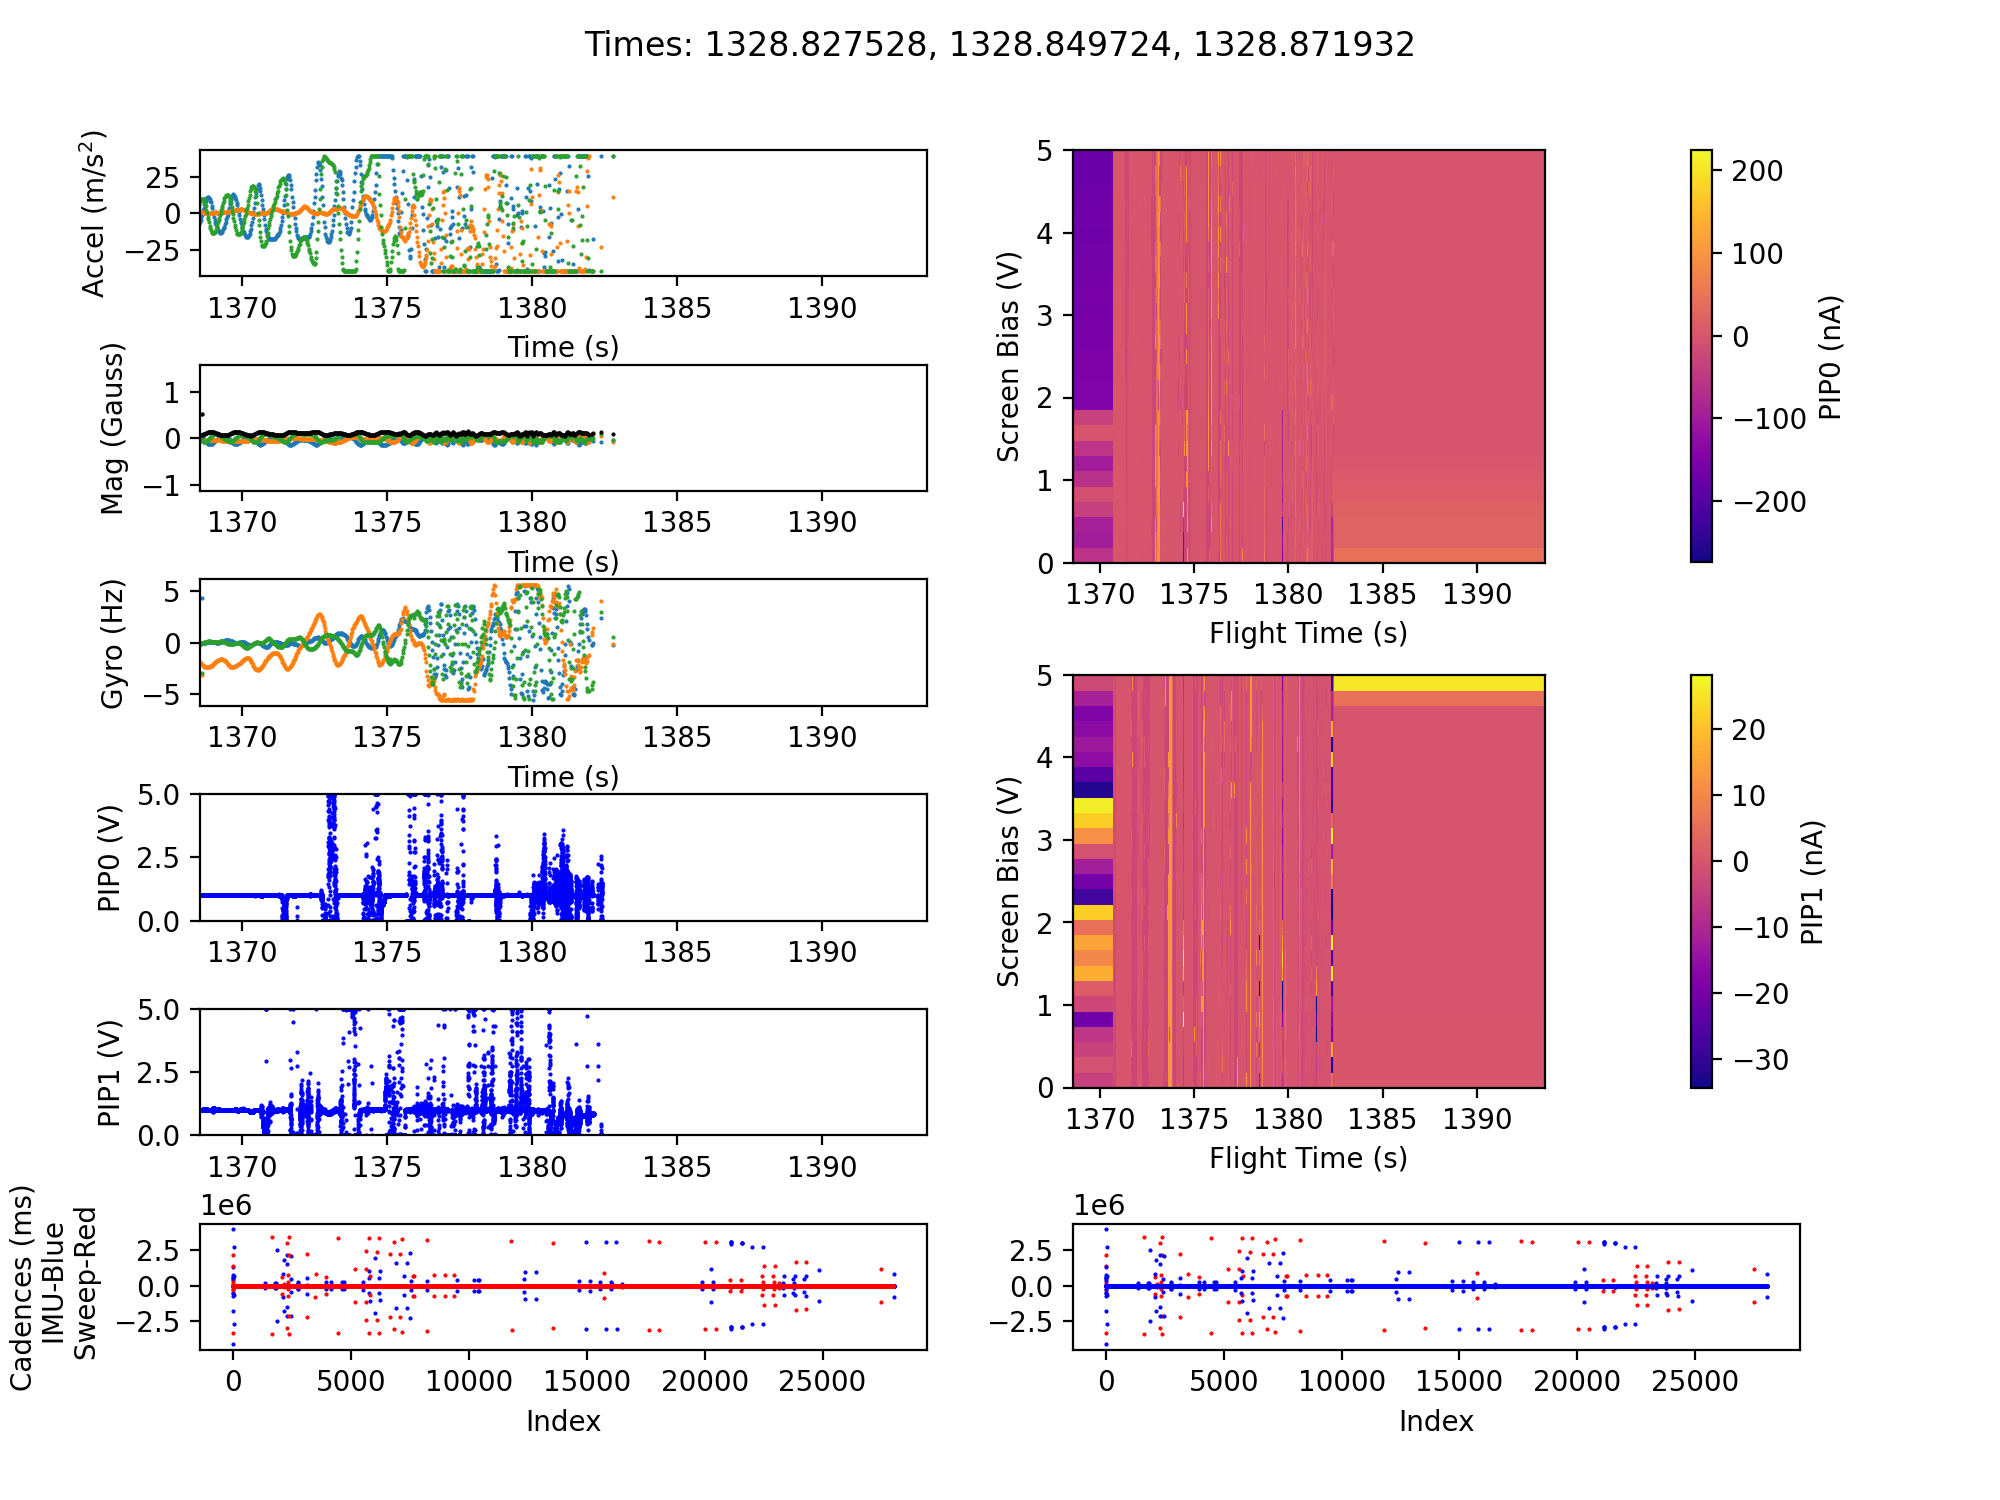

1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done


<ipython-input-34-9e0878061d36>:107: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
<ipython-input-34-9e0878061d36>:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])


9 Done


In [34]:
matplotlib.use('nbagg')
import matplotlib.cm as cm
import scipy.signal as sig
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat
from __future__ import division

dots = True

gs_left = plt.GridSpec(6, 2,  hspace=0.7)

# Set up dots or not more cleanly
line_style = '-'
if dots:
    line_style = '.'

markersize = 1
if plt.fignum_exists(1): plt.close(1)
fig = plt.figure(1, figsize=(10, 7.5))

# Accel
ax1 = fig.add_subplot(gs_left[0,0])
plt.plot(imuPlot, axPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, ayPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, azPlot, line_style, markersize=markersize) 
plt.ylabel("Accel (m/s$^2$)")
#plt.ylim([-2, 2])
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("1 Done")

# Mag
fig.add_subplot(gs_left[1,0],sharex=ax1)
plt.plot(imuPlot, mxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, myPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, mzPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, magfullPlot, line_style, markersize=markersize, color='black')
#plt.ylim([-0.2, 0.25])
if np.isin('mag', list(ylims_dct.keys())): plt.ylim(ylims_dct['mag'])
plt.ylabel("Mag (Gauss)") 
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("2 Done")

# Gyro
fig.add_subplot(gs_left[2,0],sharex=ax1)
plt.plot(imuPlot, gxPlot, line_style, markersize=markersize) 
plt.plot(imuPlot, gyPlot, line_style, markersize=markersize)  
plt.plot(imuPlot, gzPlot, line_style, markersize=markersize) 
plt.ylabel("Gyro (Hz)")
#plt.ylim([-0.5, 0.5])  
#plt.xlim([75, 100])
plt.xticks(visible=True)
plt.xlabel("Time (s)")
print ("3 Done")

# First PIP (line)
axP = fig.add_subplot(gs_left[3,0], sharex=ax1)
plt.plot(sweepTimeLPlot, pip0LPlot, line_style, markersize=markersize, color='blue')
plt.ylabel("PIP0 (V)")
#plt.ylim([0.8, 1.2])
plt.ylim(pip0LnLims)
plt.xlim(xlims)
print("4 Done")

# Second PIP (line)
fig.add_subplot(gs_left[4,0], sharex=axP)
plt.plot(sweepTimeLPlot, pip1LPlot, line_style, markersize=markersize, color='blue')
#plt.ylim([0.8, 1.2])
plt.xlim(xlims2)
plt.ylim(pip1LnLims)
plt.ylabel("PIP1 (V)")
print("5 Done")

# Cadence (sweep on top)
axis2 = fig.add_subplot(gs_left[5,0])
plt.plot(np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
#plt.ylim([20,50])
#plt.xlim([2000,4000])
plt.ylabel("Cadences (ms)\n IMU-Blue\n Sweep-Red")
plt.xlabel("Index")
print ("6 Done")

# Cadence (imu on top)
fig.add_subplot(gs_left[5,1], sharex=axis2, sharey=axis2)
plt.plot(np.diff(sweepPlot)*1E3, line_style, color='red', markersize=markersize)
plt.plot(np.diff(imuPlot)*1E3, line_style, color='blue', markersize=markersize)
#plt.ylim([20,50])
#plt.xlim([2000,4000])
plt.xlabel("Index")
print ("7 Done")

# **Plot sweep time vs sweep data (Color plots)**

# commands to reorient pip array to match with other axes
pip0_rot = np.rot90(pip0Plot, k=1, axes=(0, 1))
pip1_rot = np.rot90(pip1Plot, k=1, axes=(0, 1))

sweep_voltage = np.linspace(0,5,28)

line_style = '-'

ax1 = plt.subplot2grid((5,2),(0,1),rowspan = 2, sharex=axP)
plt.pcolormesh(sweepPlot, sweep_voltage, pip0_rot, cmap='plasma', **cplt_kwargs['pip0'])
plt.xlim(xlims)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP0 (nA)")
print ("8 Done")

ax1 = plt.subplot2grid((5,2),(2,1),rowspan = 2, sharex=ax1)
plt.pcolormesh(sweepPlot, sweep_voltage, pip1_rot, cmap='plasma', **cplt_kwargs['pip1'])
plt.xlim(xlims2)
ax1.set_xlabel("Flight Time (s)")
ax1.set_ylabel("Screen Bias (V)")
cb = plt.colorbar(pad = 0.2)
cb.set_label("PIP1 (nA)")
print ("9 Done")
        
# Adjust figure
fig.subplots_adjust(right=.90)
fig.subplots_adjust(left=0.10)
fig.subplots_adjust(top=0.90)
fig.subplots_adjust(bottom=0.10)
fig.subplots_adjust(hspace=0.75)

if interruptValue and len(interruptArray) > 100:
    interruptNum = str(interruptArray[100]-577.271) + " seconds"
else:
    interruptNum = "None"
if interruptNum == "None" and not alwaysPrintInterrupt: interruptStr = ''
else: interruptStr = '\nInterrupt Time: %s'

if not np.all(np.isin([interruptOffset, T0_offset], [0])): 
    subTitle = "\n(modified %ss for interrupt offset, %s for flight time)" %(interruptOffset, T0_offset)
else: subTitle=""
plt.suptitle(file_name+": Data from Shield %s (Version: %s)%s%s" 
             %(shieldID, version, interruptStr, subTitle), fontweight='bold')

plt.show()

In [22]:
## %% For ADC Calibrations %%
# Select PIP, step voltage difference and offset from start/end of step
pipLData = pip0LPlot.copy() # For Checking PIP 0 
# pipLData = pip1LPlot.copy() # For Checking PIP 1
dV = .2 # step voltage difference 
dStep = 10 # Offset (in # of points) from start/end of step

diff = np.diff(pipLData)
locs = np.where(dV<=np.abs(diff))[0]
print('Times %s\n' % (sweepTimeLPlot[locs])) 
for sloc, eloc in zip(locs[0:-1], locs[1:]): 
    avg = np.mean(pipLData[sloc+dStep:eloc-dStep])
    print('Times %.2f-%.2fs: Average %.3f V' % (sweepTimeLPlot[sloc+dStep], sweepTimeLPlot[eloc-dStep-1], avg))

Times [314.77236743 314.77308171 315.51431429 ... 940.36194286 940.36265714
 940.36337143]

Times 314.85-314.77s: Average nan V
Times 314.85-315.46s: Average 1.014 V
Times 315.52-315.46s: Average nan V
Times 315.52-315.51s: Average nan V
Times 315.53-315.51s: Average nan V
Times 315.71-315.52s: Average nan V
Times 315.71-315.52s: Average nan V
Times 315.71-315.52s: Average nan V
Times 315.71-315.52s: Average nan V
Times 315.71-315.52s: Average nan V
Times 315.71-316.34s: Average 1.014 V
Times 316.36-316.34s: Average nan V
Times 316.36-316.36s: Average nan V
Times 316.37-316.36s: Average nan V
Times 316.37-316.36s: Average nan V
Times 316.37-316.36s: Average nan V
Times 316.37-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Times 316.38-316.36s: Average nan V
Time

/Users/magda/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/magda/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Times 373.88-373.86s: Average nan V
Times 373.88-373.86s: Average nan V
Times 373.88-373.87s: Average nan V
Times 373.88-373.87s: Average nan V
Times 373.89-373.87s: Average nan V
Times 373.89-373.87s: Average nan V
Times 373.89-373.87s: Average nan V
Times 373.89-373.87s: Average nan V
Times 373.89-373.87s: Average nan V
Times 373.89-373.88s: Average nan V
Times 373.89-373.88s: Average nan V
Times 373.89-373.88s: Average nan V
Times 373.89-373.88s: Average nan V
Times 373.90-373.88s: Average nan V
Times 373.90-373.88s: Average nan V
Times 373.90-373.88s: Average nan V
Times 373.90-373.88s: Average nan V
Times 373.90-373.88s: Average nan V
Times 373.90-373.89s: Average nan V
Times 373.90-373.89s: Average nan V
Times 373.90-373.89s: Average nan V
Times 373.91-373.89s: Average nan V
Times 373.91-373.89s: Average nan V
Times 373.91-373.89s: Average nan V
Times 373.91-373.89s: Average nan V
Times 373.91-373.89s: Average nan V
Times 373.91-373.90s: Average nan V
Times 373.91-373.90s: Avera

Times 404.78-404.79s: Average 1.020 V
Times 404.80-404.81s: Average 1.028 V
Times 404.83-404.83s: Average 1.041 V
Times 404.85-404.85s: Average 1.055 V
Times 404.87-404.88s: Average 1.073 V
Times 404.89-404.90s: Average 1.070 V
Times 404.91-404.92s: Average 1.035 V
Times 404.94-404.94s: Average 1.017 V
Times 404.96-404.96s: Average 1.012 V
Times 404.98-404.99s: Average 1.010 V
Times 405.00-405.01s: Average 1.010 V
Times 405.03-405.03s: Average 1.009 V
Times 405.05-405.05s: Average 1.010 V
Times 405.07-405.50s: Average 1.025 V
Times 405.51-405.52s: Average 1.014 V
Times 405.54-405.53s: Average nan V
Times 405.55-405.56s: Average 1.018 V
Times 405.58-405.59s: Average 1.053 V
Times 405.60-405.61s: Average 1.065 V
Times 405.62-405.63s: Average 1.056 V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Average nan V
Times 405.65-405.63s: Aver

Times 431.42-431.42s: Average nan V
Times 431.44-431.42s: Average nan V
Times 431.44-431.42s: Average nan V
Times 431.44-431.43s: Average nan V
Times 431.44-431.44s: Average 1.008 V
Times 431.46-431.44s: Average nan V
Times 431.46-431.45s: Average nan V
Times 431.47-431.47s: Average 1.008 V
Times 431.48-431.47s: Average nan V
Times 431.49-431.49s: Average 1.008 V
Times 431.51-431.49s: Average nan V
Times 431.51-431.52s: Average 1.009 V
Times 431.53-431.54s: Average 1.010 V
Times 431.55-431.56s: Average 1.011 V
Times 431.58-431.87s: Average 1.033 V
Times 431.89-431.89s: Average 1.013 V
Times 431.91-431.91s: Average 1.013 V
Times 431.93-431.94s: Average 1.013 V
Times 431.95-431.95s: Average 1.013 V
Times 431.97-431.96s: Average nan V
Times 431.98-431.98s: Average 1.013 V
Times 431.99-431.98s: Average nan V
Times 431.99-431.98s: Average nan V
Times 432.00-432.00s: Average 1.013 V
Times 432.02-432.00s: Average nan V
Times 432.02-432.00s: Average nan V
Times 432.02-432.02s: Average nan V
Ti

Times 442.63-442.61s: Average nan V
Times 442.63-442.61s: Average nan V
Times 442.63-442.61s: Average nan V
Times 442.63-442.62s: Average nan V
Times 442.63-442.63s: Average nan V
Times 442.65-442.63s: Average nan V
Times 442.65-442.63s: Average nan V
Times 442.65-442.63s: Average nan V
Times 442.65-442.64s: Average nan V
Times 442.65-442.65s: Average nan V
Times 442.67-442.65s: Average nan V
Times 442.67-442.66s: Average nan V
Times 442.67-442.66s: Average nan V
Times 442.68-442.68s: Average nan V
Times 442.69-442.68s: Average nan V
Times 442.69-442.68s: Average nan V
Times 442.69-442.68s: Average nan V
Times 442.70-442.70s: Average 1.008 V
Times 442.72-442.70s: Average nan V
Times 442.72-442.70s: Average nan V
Times 442.72-442.72s: Average 1.009 V
Times 442.74-442.72s: Average nan V
Times 442.74-442.73s: Average nan V
Times 442.74-442.74s: Average 1.009 V
Times 442.76-442.74s: Average nan V
Times 442.76-442.75s: Average nan V
Times 442.77-442.77s: Average 1.010 V
Times 442.78-442.77s

Times 452.26-452.24s: Average nan V
Times 452.26-452.25s: Average nan V
Times 452.26-452.25s: Average nan V
Times 452.27-452.27s: Average nan V
Times 452.28-452.27s: Average nan V
Times 452.28-452.27s: Average nan V
Times 452.28-452.27s: Average nan V
Times 452.29-452.29s: Average 1.008 V
Times 452.31-452.29s: Average nan V
Times 452.31-452.29s: Average nan V
Times 452.31-452.31s: Average 1.008 V
Times 452.33-452.31s: Average nan V
Times 452.33-452.31s: Average nan V
Times 452.33-452.32s: Average nan V
Times 452.33-452.33s: Average 1.008 V
Times 452.35-452.34s: Average nan V
Times 452.35-452.34s: Average nan V
Times 452.36-452.36s: Average 1.009 V
Times 452.37-452.36s: Average nan V
Times 452.38-452.38s: Average 1.010 V
Times 452.40-452.38s: Average nan V
Times 452.40-452.41s: Average 1.011 V
Times 452.42-452.43s: Average 1.012 V
Times 452.44-452.56s: Average 1.035 V
Times 452.57-452.56s: Average nan V
Times 452.58-452.69s: Average 1.034 V
Times 452.71-452.72s: Average 1.013 V
Times 45

Times 461.72-461.70s: Average nan V
Times 461.72-461.71s: Average nan V
Times 461.72-461.72s: Average nan V
Times 461.74-461.72s: Average nan V
Times 461.74-461.72s: Average nan V
Times 461.74-461.72s: Average nan V
Times 461.74-461.73s: Average nan V
Times 461.75-461.74s: Average nan V
Times 461.76-461.75s: Average nan V
Times 461.76-461.75s: Average nan V
Times 461.76-461.75s: Average nan V
Times 461.76-461.75s: Average nan V
Times 461.77-461.77s: Average nan V
Times 461.78-461.77s: Average nan V
Times 461.78-461.77s: Average nan V
Times 461.79-461.77s: Average nan V
Times 461.79-461.77s: Average nan V
Times 461.79-461.77s: Average nan V
Times 461.79-461.79s: Average nan V
Times 461.80-461.79s: Average nan V
Times 461.81-461.79s: Average nan V
Times 461.81-461.79s: Average nan V
Times 461.81-461.79s: Average nan V
Times 461.81-461.80s: Average nan V
Times 461.81-461.81s: Average nan V
Times 461.83-461.81s: Average nan V
Times 461.83-461.81s: Average nan V
Times 461.83-461.81s: Averag

Times 470.49-470.47s: Average nan V
Times 470.49-470.47s: Average nan V
Times 470.49-470.48s: Average nan V
Times 470.49-470.49s: Average 1.012 V
Times 470.51-470.49s: Average nan V
Times 470.51-470.49s: Average nan V
Times 470.51-470.50s: Average nan V
Times 470.52-470.51s: Average nan V
Times 470.53-470.52s: Average nan V
Times 470.53-470.52s: Average nan V
Times 470.53-470.52s: Average nan V
Times 470.54-470.54s: Average nan V
Times 470.55-470.54s: Average nan V
Times 470.55-470.54s: Average nan V
Times 470.56-470.54s: Average nan V
Times 470.56-470.56s: Average nan V
Times 470.58-470.56s: Average nan V
Times 470.58-470.56s: Average nan V
Times 470.58-470.56s: Average nan V
Times 470.58-470.58s: Average nan V
Times 470.60-470.58s: Average nan V
Times 470.60-470.58s: Average nan V
Times 470.60-470.59s: Average nan V
Times 470.60-470.60s: Average nan V
Times 470.62-470.60s: Average nan V
Times 470.62-470.60s: Average nan V
Times 470.62-470.61s: Average nan V
Times 470.63-470.63s: Aver

Times 480.24-480.24s: Average nan V
Times 3761.09-480.24s: Average nan V
Times 3761.09-480.24s: Average nan V
Times 3761.09-480.24s: Average nan V
Times 3761.09-480.25s: Average nan V
Times 3761.10-3761.10s: Average 1.004 V
Times 480.26-3761.10s: Average nan V
Times 480.26-3761.10s: Average nan V
Times 480.26-480.26s: Average nan V
Times 480.28-480.26s: Average nan V
Times 480.28-480.26s: Average nan V
Times 480.28-480.26s: Average nan V
Times 480.28-480.27s: Average nan V
Times 480.28-480.28s: Average nan V
Times 480.30-480.28s: Average nan V
Times 480.30-480.28s: Average nan V
Times 480.30-480.28s: Average nan V
Times 480.30-480.29s: Average nan V
Times 480.31-480.30s: Average nan V
Times 480.32-480.31s: Average nan V
Times 480.32-480.31s: Average nan V
Times 480.32-480.31s: Average nan V
Times 480.33-480.33s: Average nan V
Times 480.34-480.33s: Average nan V
Times 480.35-480.33s: Average nan V
Times 480.35-480.33s: Average nan V
Times 480.35-480.33s: Average nan V
Times 480.35-480.3

Times 490.01-490.01s: Average 1.008 V
Times 490.02-490.01s: Average nan V
Times 490.03-490.01s: Average nan V
Times 490.03-490.03s: Average 1.009 V
Times 490.05-490.03s: Average nan V
Times 490.05-490.03s: Average nan V
Times 490.05-490.05s: Average 1.010 V
Times 490.07-490.06s: Average nan V
Times 490.07-490.08s: Average 1.011 V
Times 490.09-490.08s: Average nan V
Times 490.10-490.10s: Average 1.012 V
Times 490.12-490.12s: Average 1.012 V
Times 490.14-490.15s: Average 1.012 V
Times 490.16-490.17s: Average 1.012 V
Times 490.18-490.19s: Average 1.012 V
Times 490.21-490.21s: Average 1.012 V
Times 490.23-490.23s: Average 1.013 V
Times 490.25-490.26s: Average 1.012 V
Times 490.27-490.28s: Average 1.013 V
Times 3761.09-490.28s: Average nan V
Times 3761.10-3761.10s: Average 1.004 V
Times 490.29-3761.10s: Average nan V
Times 490.29-3761.10s: Average nan V
Times 490.30-490.30s: Average 1.013 V
Times 490.32-490.32s: Average 1.013 V
Times 490.34-490.35s: Average 1.013 V
Times 490.36-490.37s: Ave

Times 499.59-499.58s: Average nan V
Times 499.59-499.58s: Average nan V
Times 499.59-499.58s: Average nan V
Times 499.60-499.60s: Average 1.008 V
Times 499.62-499.60s: Average nan V
Times 499.62-499.60s: Average nan V
Times 499.62-499.62s: Average 1.008 V
Times 499.64-499.62s: Average nan V
Times 499.64-499.62s: Average nan V
Times 499.64-499.64s: Average 1.009 V
Times 499.66-499.65s: Average nan V
Times 499.66-499.67s: Average 1.010 V
Times 499.68-499.67s: Average nan V
Times 499.69-499.69s: Average 1.011 V
Times 499.71-499.71s: Average 1.012 V
Times 499.73-499.74s: Average 1.012 V
Times 499.75-499.76s: Average 1.012 V
Times 499.78-499.94s: Average 1.039 V
Times 499.95-499.96s: Average 1.013 V
Times 499.97-499.98s: Average 1.013 V
Times 500.00-500.00s: Average 1.013 V
Times 500.02-500.02s: Average 1.013 V
Times 500.04-500.02s: Average nan V
Times 500.04-500.04s: Average 1.013 V
Times 500.06-500.05s: Average nan V
Times 500.06-500.06s: Average 1.012 V
Times 500.08-500.07s: Average nan 

Times 507.47-507.46s: Average nan V
Times 507.47-507.46s: Average nan V
Times 507.47-507.46s: Average nan V
Times 507.48-507.48s: Average nan V
Times 507.49-507.48s: Average nan V
Times 507.50-507.48s: Average nan V
Times 507.50-507.48s: Average nan V
Times 507.50-507.50s: Average nan V
Times 507.52-507.50s: Average nan V
Times 507.52-507.50s: Average nan V
Times 507.52-507.51s: Average nan V
Times 507.52-507.52s: Average nan V
Times 507.54-507.52s: Average nan V
Times 507.54-507.52s: Average nan V
Times 507.54-507.53s: Average nan V
Times 507.55-507.54s: Average nan V
Times 507.56-507.55s: Average nan V
Times 507.56-507.55s: Average nan V
Times 507.56-507.55s: Average nan V
Times 507.57-507.57s: Average 1.009 V
Times 507.58-507.57s: Average nan V
Times 507.59-507.57s: Average nan V
Times 507.59-507.59s: Average 1.009 V
Times 507.61-507.59s: Average nan V
Times 507.61-507.59s: Average nan V
Times 507.61-507.59s: Average nan V
Times 507.61-507.61s: Average 1.009 V
Times 507.63-507.61s: 

Times 517.11-517.09s: Average nan V
Times 517.11-517.09s: Average nan V
Times 517.11-517.10s: Average nan V
Times 517.11-517.11s: Average nan V
Times 517.13-517.11s: Average nan V
Times 517.13-517.11s: Average nan V
Times 517.13-517.12s: Average nan V
Times 517.14-517.13s: Average nan V
Times 517.15-517.14s: Average nan V
Times 517.15-517.14s: Average nan V
Times 517.15-517.14s: Average nan V
Times 517.16-517.16s: Average 1.009 V
Times 517.17-517.16s: Average nan V
Times 517.18-517.16s: Average nan V
Times 517.18-517.18s: Average 1.009 V
Times 517.20-517.18s: Average nan V
Times 517.20-517.18s: Average nan V
Times 517.20-517.20s: Average 1.010 V
Times 517.22-517.20s: Average nan V
Times 517.22-517.21s: Average nan V
Times 517.22-517.22s: Average 1.010 V
Times 517.24-517.23s: Average nan V
Times 517.24-517.23s: Average nan V
Times 517.25-517.25s: Average 1.009 V
Times 517.26-517.25s: Average nan V
Times 517.27-517.25s: Average nan V
Times 517.27-517.27s: Average 1.009 V
Times 517.29-517

Times 527.46-527.46s: Average nan V
Times 527.47-527.46s: Average nan V
Times 527.48-527.46s: Average nan V
Times 527.48-527.46s: Average nan V
Times 527.48-527.48s: Average nan V
Times 527.50-527.48s: Average nan V
Times 527.50-527.48s: Average nan V
Times 527.50-527.49s: Average nan V
Times 527.50-527.50s: Average nan V
Times 527.52-527.50s: Average nan V
Times 527.52-527.50s: Average nan V
Times 527.52-527.51s: Average nan V
Times 527.53-527.52s: Average nan V
Times 527.54-527.53s: Average nan V
Times 527.54-527.53s: Average nan V
Times 527.54-527.53s: Average nan V
Times 527.55-527.55s: Average nan V
Times 527.56-527.55s: Average nan V
Times 527.56-527.55s: Average nan V
Times 527.57-527.55s: Average nan V
Times 527.57-527.57s: Average 1.009 V
Times 527.59-527.57s: Average nan V
Times 527.59-527.57s: Average nan V
Times 527.59-527.59s: Average 1.009 V
Times 527.61-527.59s: Average nan V
Times 527.61-527.60s: Average nan V
Times 527.61-527.61s: Average 1.009 V
Times 527.63-527.61s: 

Times 539.49-539.47s: Average nan V
Times 539.49-539.47s: Average nan V
Times 539.49-539.47s: Average nan V
Times 539.49-539.49s: Average nan V
Times 539.51-539.49s: Average nan V
Times 539.51-539.49s: Average nan V
Times 539.51-539.50s: Average nan V
Times 539.51-539.51s: Average nan V
Times 539.53-539.51s: Average nan V
Times 539.53-539.51s: Average nan V
Times 539.53-539.52s: Average nan V
Times 539.54-539.53s: Average nan V
Times 539.55-539.54s: Average nan V
Times 539.55-539.54s: Average nan V
Times 539.55-539.54s: Average nan V
Times 539.56-539.56s: Average 1.009 V
Times 539.57-539.56s: Average nan V
Times 539.58-539.56s: Average nan V
Times 539.58-539.58s: Average 1.008 V
Times 539.60-539.58s: Average nan V
Times 539.60-539.58s: Average nan V
Times 539.60-539.60s: Average 1.008 V
Times 539.62-539.60s: Average nan V
Times 539.62-539.61s: Average nan V
Times 539.62-539.62s: Average 1.008 V
Times 539.64-539.62s: Average nan V
Times 539.64-539.63s: Average nan V
Times 539.65-539.65s

Times 551.35-551.35s: Average 1.013 V
Times 551.36-551.35s: Average nan V
Times 551.37-551.37s: Average 1.013 V
Times 551.39-551.37s: Average nan V
Times 551.39-551.39s: Average 1.012 V
Times 551.41-551.40s: Average nan V
Times 551.41-551.41s: Average 1.013 V
Times 551.43-551.42s: Average nan V
Times 551.43-551.43s: Average 1.013 V
Times 551.45-551.44s: Average nan V
Times 551.45-551.44s: Average nan V
Times 551.46-551.46s: Average 1.013 V
Times 551.47-551.46s: Average nan V
Times 551.47-551.46s: Average nan V
Times 551.48-551.48s: Average 1.013 V
Times 551.50-551.48s: Average nan V
Times 551.50-551.48s: Average nan V
Times 551.50-551.50s: Average 1.013 V
Times 551.52-551.50s: Average nan V
Times 551.52-551.51s: Average nan V
Times 551.52-551.52s: Average 1.012 V
Times 551.54-551.52s: Average nan V
Times 551.54-551.53s: Average nan V
Times 551.55-551.55s: Average 1.012 V
Times 551.56-551.55s: Average nan V
Times 551.56-551.55s: Average nan V
Times 551.57-551.57s: Average 1.010 V
Times 

Times 562.66-562.65s: Average nan V
Times 562.67-562.67s: Average 1.013 V
Times 562.68-562.67s: Average nan V
Times 562.69-562.67s: Average nan V
Times 562.69-562.69s: Average 1.013 V
Times 562.71-562.69s: Average nan V
Times 562.71-562.69s: Average nan V
Times 562.71-562.71s: Average 1.013 V
Times 562.73-562.71s: Average nan V
Times 562.73-562.72s: Average nan V
Times 562.73-562.73s: Average 1.013 V
Times 562.75-562.73s: Average nan V
Times 562.75-562.74s: Average nan V
Times 562.76-562.76s: Average 1.013 V
Times 562.77-562.76s: Average nan V
Times 562.77-562.76s: Average nan V
Times 562.78-562.78s: Average 1.012 V
Times 562.80-562.78s: Average nan V
Times 562.80-562.78s: Average nan V
Times 562.80-562.80s: Average 1.011 V
Times 562.82-562.80s: Average nan V
Times 562.82-562.81s: Average nan V
Times 562.82-562.82s: Average 1.010 V
Times 562.84-562.82s: Average nan V
Times 562.84-562.83s: Average nan V
Times 562.85-562.85s: Average 1.010 V
Times 562.86-562.85s: Average nan V
Times 562.

Times 574.52-574.53s: Average 1.013 V
Times 574.54-574.55s: Average 1.013 V
Times 574.57-574.57s: Average 1.012 V
Times 574.59-574.59s: Average 1.013 V
Times 574.61-574.59s: Average nan V
Times 574.61-574.61s: Average 1.013 V
Times 574.63-574.62s: Average nan V
Times 574.63-574.63s: Average 1.013 V
Times 574.65-574.64s: Average nan V
Times 574.66-574.66s: Average 1.013 V
Times 574.67-574.66s: Average nan V
Times 574.67-574.66s: Average nan V
Times 574.68-574.68s: Average 1.013 V
Times 574.70-574.68s: Average nan V
Times 574.70-574.68s: Average nan V
Times 574.70-574.70s: Average 1.013 V
Times 574.72-574.70s: Average nan V
Times 574.72-574.71s: Average nan V
Times 574.72-574.72s: Average 1.013 V
Times 574.74-574.72s: Average nan V
Times 574.74-574.73s: Average nan V
Times 574.74-574.74s: Average 1.013 V
Times 574.76-574.75s: Average nan V
Times 574.76-574.75s: Average nan V
Times 574.77-574.77s: Average 1.013 V
Times 574.78-574.77s: Average nan V
Times 574.78-574.77s: Average nan V
Time

Times 591.52-591.51s: Average nan V
Times 591.53-591.53s: Average 1.013 V
Times 591.54-591.53s: Average nan V
Times 591.55-591.53s: Average nan V
Times 591.55-591.55s: Average 1.013 V
Times 591.57-591.55s: Average nan V
Times 591.57-591.55s: Average nan V
Times 591.57-591.57s: Average 1.013 V
Times 591.59-591.57s: Average nan V
Times 591.59-591.58s: Average nan V
Times 591.59-591.59s: Average 1.013 V
Times 591.61-591.59s: Average nan V
Times 591.61-591.60s: Average nan V
Times 591.62-591.62s: Average 1.012 V
Times 591.63-591.62s: Average nan V
Times 591.63-591.62s: Average nan V
Times 591.64-591.64s: Average 1.010 V
Times 591.66-591.64s: Average nan V
Times 591.66-591.64s: Average nan V
Times 591.66-591.66s: Average 1.009 V
Times 591.68-591.66s: Average nan V
Times 591.68-591.67s: Average nan V
Times 591.68-591.68s: Average 1.009 V
Times 591.70-591.69s: Average nan V
Times 591.71-591.71s: Average 1.009 V
Times 591.72-591.71s: Average nan V
Times 591.73-591.73s: Average 1.008 V
Times 59

Times 604.35-604.34s: Average nan V
Times 604.35-604.34s: Average nan V
Times 604.36-604.36s: Average 1.013 V
Times 604.38-604.36s: Average nan V
Times 604.38-604.36s: Average nan V
Times 604.38-604.38s: Average 1.013 V
Times 604.40-604.38s: Average nan V
Times 604.40-604.39s: Average nan V
Times 604.40-604.40s: Average 1.013 V
Times 604.42-604.40s: Average nan V
Times 604.42-604.41s: Average nan V
Times 604.43-604.43s: Average 1.013 V
Times 604.44-604.43s: Average nan V
Times 604.44-604.43s: Average nan V
Times 604.45-604.45s: Average 1.012 V
Times 604.47-604.45s: Average nan V
Times 604.47-604.45s: Average nan V
Times 604.47-604.47s: Average 1.010 V
Times 1261.49-604.47s: Average nan V
Times 1261.49-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1261.50-604.48s: Average nan V
Times 1

Times 618.67-618.66s: Average nan V
Times 618.68-618.68s: Average 1.013 V
Times 618.70-618.68s: Average nan V
Times 618.70-618.70s: Average 1.013 V
Times 618.72-618.71s: Average nan V
Times 618.72-618.72s: Average 1.013 V
Times 618.74-618.72s: Average nan V
Times 618.74-618.73s: Average nan V
Times 618.74-618.74s: Average 1.013 V
Times 618.76-618.75s: Average nan V
Times 618.76-618.75s: Average nan V
Times 618.77-618.77s: Average 1.013 V
Times 618.78-618.77s: Average nan V
Times 618.78-618.77s: Average nan V
Times 618.79-618.79s: Average 1.013 V
Times 618.81-618.79s: Average nan V
Times 618.81-618.81s: Average 1.013 V
Times 618.83-618.81s: Average nan V
Times 618.83-618.82s: Average nan V
Times 618.83-618.83s: Average 1.013 V
Times 618.85-618.84s: Average nan V
Times 618.86-618.86s: Average 1.013 V
Times 618.87-618.86s: Average nan V
Times 618.87-618.86s: Average nan V
Times 618.88-618.88s: Average 1.012 V
Times 618.90-618.88s: Average nan V
Times 618.90-618.88s: Average nan V
Times 61

Times 633.71-633.71s: Average 1.013 V
Times 633.73-633.73s: Average 1.013 V
Times 633.75-633.76s: Average 1.013 V
Times 633.77-633.78s: Average 1.013 V
Times 633.80-633.80s: Average 1.013 V
Times 633.82-633.82s: Average 1.012 V
Times 633.84-633.85s: Average 1.013 V
Times 633.86-633.87s: Average 1.013 V
Times 633.89-633.89s: Average 1.013 V
Times 633.91-633.91s: Average 1.013 V
Times 633.93-633.93s: Average 1.013 V
Times 633.95-633.95s: Average 1.013 V
Times 633.97-633.96s: Average nan V
Times 633.97-633.97s: Average 1.013 V
Times 633.99-633.98s: Average nan V
Times 634.00-634.00s: Average 1.013 V
Times 634.01-634.00s: Average nan V
Times 634.02-634.02s: Average 1.013 V
Times 634.04-634.02s: Average nan V
Times 634.04-634.04s: Average 1.013 V
Times 634.06-634.05s: Average nan V
Times 634.06-634.06s: Average 1.013 V
Times 634.08-634.07s: Average nan V
Times 634.09-634.09s: Average 1.012 V
Times 634.10-634.09s: Average nan V
Times 634.11-634.11s: Average 1.013 V
Times 634.12-634.11s: Aver

Times 653.33-653.33s: Average 1.013 V
Times 653.35-653.34s: Average nan V
Times 653.35-653.35s: Average 1.012 V
Times 653.37-653.36s: Average nan V
Times 653.38-653.38s: Average 1.010 V
Times 653.40-653.40s: Average 1.009 V
Times 653.42-653.43s: Average 1.008 V
Times 653.44-653.45s: Average 1.008 V
Times 653.47-653.47s: Average 1.008 V
Times 653.49-653.49s: Average 1.008 V
Times 653.51-653.52s: Average 1.008 V
Times 653.53-653.54s: Average 1.008 V
Times 653.55-653.56s: Average 1.009 V
Times 653.58-653.58s: Average 1.010 V
Times 653.60-653.60s: Average 1.011 V
Times 653.62-653.63s: Average 1.012 V
Times 653.64-653.65s: Average 1.012 V
Times 653.67-653.67s: Average 1.012 V
Times 653.69-653.69s: Average 1.013 V
Times 653.71-653.71s: Average 1.013 V
Times 653.73-653.74s: Average 1.013 V
Times 653.75-653.76s: Average 1.013 V
Times 653.78-653.78s: Average 1.013 V
Times 653.80-653.80s: Average 1.013 V
Times 653.82-653.83s: Average 1.013 V
Times 653.84-653.85s: Average 1.013 V
Times 653.87-653

Times 674.36-674.36s: Average 1.008 V
Times 674.38-674.38s: Average 1.008 V
Times 674.40-674.41s: Average 1.009 V
Times 674.42-674.43s: Average 1.010 V
Times 674.44-674.45s: Average 1.011 V
Times 674.47-674.47s: Average 1.012 V
Times 674.49-674.49s: Average 1.012 V
Times 674.51-674.52s: Average 1.012 V
Times 674.53-674.54s: Average 1.013 V
Times 674.56-674.56s: Average 1.013 V
Times 674.58-674.58s: Average 1.013 V
Times 674.60-674.61s: Average 1.013 V
Times 674.62-674.63s: Average 1.013 V
Times 674.64-674.65s: Average 1.013 V
Times 674.67-674.67s: Average 1.013 V
Times 674.69-674.69s: Average 1.013 V
Times 674.71-674.72s: Average 1.013 V
Times 674.73-674.74s: Average 1.013 V
Times 674.76-674.76s: Average 1.013 V
Times 674.78-674.78s: Average 1.013 V
Times 674.80-674.80s: Average 1.013 V
Times 674.82-674.80s: Average nan V
Times 674.82-674.82s: Average 1.013 V
Times 674.84-674.83s: Average nan V
Times 674.84-674.84s: Average 1.013 V
Times 674.86-674.85s: Average nan V
Times 674.87-674.8

Times 694.76-694.76s: Average 1.013 V
Times 694.78-694.78s: Average 1.013 V
Times 694.80-694.80s: Average 1.013 V
Times 694.82-694.81s: Average nan V
Times 694.82-694.82s: Average 1.013 V
Times 694.84-694.83s: Average nan V
Times 694.85-694.85s: Average 1.013 V
Times 694.86-694.85s: Average nan V
Times 694.87-694.87s: Average 1.013 V
Times 694.89-694.87s: Average nan V
Times 694.89-694.89s: Average 1.013 V
Times 694.91-694.90s: Average nan V
Times 694.91-694.91s: Average 1.013 V
Times 694.93-694.92s: Average nan V
Times 694.94-694.94s: Average 1.013 V
Times 694.95-694.94s: Average nan V
Times 694.96-694.96s: Average 1.013 V
Times 694.97-694.96s: Average nan V
Times 694.98-694.98s: Average 1.013 V
Times 695.00-695.01s: Average 1.013 V
Times 695.02-695.03s: Average 1.012 V
Times 695.05-695.05s: Average 1.012 V
Times 695.07-695.07s: Average 1.009 V
Times 695.09-695.10s: Average 1.009 V
Times 695.11-695.12s: Average 1.008 V
Times 695.14-695.14s: Average 1.008 V
Times 695.16-695.16s: Averag

Times 710.74-710.74s: Average 1.013 V
Times 710.76-710.74s: Average nan V
Times 710.76-710.75s: Average nan V
Times 710.76-710.76s: Average 1.013 V
Times 710.78-710.76s: Average nan V
Times 710.78-710.77s: Average nan V
Times 710.79-710.79s: Average 1.013 V
Times 710.80-710.79s: Average nan V
Times 710.80-710.79s: Average nan V
Times 710.81-710.81s: Average 1.013 V
Times 710.83-710.81s: Average nan V
Times 710.83-710.83s: Average 1.013 V
Times 710.85-710.84s: Average nan V
Times 710.85-710.85s: Average 1.013 V
Times 710.87-710.86s: Average nan V
Times 710.87-710.87s: Average 1.013 V
Times 710.89-710.88s: Average nan V
Times 710.90-710.90s: Average 1.013 V
Times 710.91-710.90s: Average nan V
Times 710.91-710.90s: Average nan V
Times 710.92-710.92s: Average 1.013 V
Times 710.94-710.92s: Average nan V
Times 710.94-710.92s: Average nan V
Times 710.94-710.94s: Average 1.013 V
Times 710.96-710.94s: Average nan V
Times 710.96-710.95s: Average nan V
Times 710.96-710.96s: Average 1.013 V
Times 

Times 722.86-722.85s: Average nan V
Times 722.86-722.86s: Average 1.013 V
Times 722.88-722.86s: Average nan V
Times 722.88-722.87s: Average nan V
Times 722.89-722.89s: Average 1.013 V
Times 722.90-722.89s: Average nan V
Times 722.90-722.89s: Average nan V
Times 722.91-722.91s: Average 1.013 V
Times 722.92-722.91s: Average nan V
Times 722.93-722.91s: Average nan V
Times 722.93-722.93s: Average 1.013 V
Times 722.95-722.93s: Average nan V
Times 722.95-722.93s: Average nan V
Times 722.95-722.95s: Average 1.012 V
Times 722.97-722.95s: Average nan V
Times 722.97-722.96s: Average nan V
Times 722.97-722.97s: Average 1.013 V
Times 722.99-722.97s: Average nan V
Times 722.99-722.98s: Average nan V
Times 723.00-723.00s: Average 1.013 V
Times 723.01-723.00s: Average nan V
Times 723.02-723.02s: Average 1.013 V
Times 723.04-723.02s: Average nan V
Times 723.04-723.04s: Average 1.013 V
Times 723.06-723.05s: Average nan V
Times 723.06-723.07s: Average 1.013 V
Times 723.08-723.09s: Average 1.012 V
Times 

Times 736.72-736.72s: Average 1.012 V
Times 736.74-736.74s: Average 1.012 V
Times 736.76-736.77s: Average 1.010 V
Times 736.78-736.79s: Average 1.010 V
Times 736.80-736.81s: Average 1.009 V
Times 736.83-736.83s: Average 1.009 V
Times 736.85-736.85s: Average 1.009 V
Times 736.87-736.88s: Average 1.009 V
Times 736.89-736.90s: Average 1.008 V
Times 736.92-736.92s: Average 1.008 V
Times 736.94-736.94s: Average 1.008 V
Times 736.96-736.96s: Average 1.009 V
Times 736.98-736.99s: Average 1.010 V
Times 737.00-737.01s: Average 1.012 V
Times 737.03-737.03s: Average 1.012 V
Times 737.05-737.05s: Average 1.012 V
Times 737.07-737.08s: Average 1.012 V
Times 737.09-737.09s: Average 1.012 V
Times 737.11-737.10s: Average nan V
Times 737.12-737.12s: Average 1.013 V
Times 737.13-737.12s: Average nan V
Times 737.14-737.14s: Average 1.013 V
Times 737.16-737.14s: Average nan V
Times 737.16-737.16s: Average 1.013 V
Times 737.18-737.16s: Average nan V
Times 737.18-737.16s: Average nan V
Times 737.18-737.18s: 

Times 750.03-750.01s: Average nan V
Times 750.03-750.02s: Average nan V
Times 750.04-750.04s: Average 1.013 V
Times 750.05-750.04s: Average nan V
Times 750.05-750.04s: Average nan V
Times 750.06-750.06s: Average 1.013 V
Times 750.08-750.06s: Average nan V
Times 750.08-750.06s: Average nan V
Times 750.08-750.08s: Average nan V
Times 750.10-750.08s: Average nan V
Times 750.10-750.08s: Average nan V
Times 750.10-750.09s: Average nan V
Times 750.10-750.10s: Average nan V
Times 750.12-750.10s: Average nan V
Times 750.12-750.10s: Average nan V
Times 750.12-750.11s: Average nan V
Times 750.12-750.12s: Average 1.013 V
Times 750.14-750.13s: Average nan V
Times 750.14-750.13s: Average nan V
Times 750.15-750.15s: Average 1.013 V
Times 750.16-750.15s: Average nan V
Times 750.16-750.15s: Average nan V
Times 750.17-750.17s: Average 1.013 V
Times 750.19-750.17s: Average nan V
Times 750.19-750.17s: Average nan V
Times 750.19-750.19s: Average 1.013 V
Times 750.21-750.19s: Average nan V
Times 750.21-750

Times 761.65-761.65s: Average 1.008 V
Times 761.67-761.67s: Average 1.008 V
Times 761.69-761.70s: Average 1.008 V
Times 761.71-761.72s: Average 1.008 V
Times 761.74-761.74s: Average 1.008 V
Times 761.76-761.76s: Average 1.008 V
Times 761.78-761.78s: Average 1.009 V
Times 761.80-761.81s: Average 1.010 V
Times 761.82-761.83s: Average 1.010 V
Times 761.85-761.85s: Average 1.012 V
Times 761.87-761.87s: Average 1.012 V
Times 761.89-761.89s: Average 1.012 V
Times 761.91-761.90s: Average nan V
Times 761.91-761.91s: Average 1.013 V
Times 761.93-761.92s: Average nan V
Times 761.93-761.94s: Average 1.013 V
Times 761.95-761.94s: Average nan V
Times 761.96-761.96s: Average 1.012 V
Times 761.97-761.96s: Average nan V
Times 761.98-761.98s: Average 1.012 V
Times 762.00-761.98s: Average nan V
Times 762.00-762.00s: Average 1.013 V
Times 762.02-762.01s: Average nan V
Times 762.02-762.02s: Average 1.013 V
Times 762.04-762.02s: Average nan V
Times 762.04-762.03s: Average nan V
Times 762.05-762.05s: Averag

Times 773.32-773.31s: Average nan V
Times 773.32-773.32s: Average nan V
Times 773.34-773.32s: Average nan V
Times 773.34-773.32s: Average nan V
Times 773.34-773.33s: Average nan V
Times 773.35-773.34s: Average nan V
Times 773.36-773.35s: Average nan V
Times 773.36-773.35s: Average nan V
Times 773.36-773.35s: Average nan V
Times 773.37-773.36s: Average nan V
Times 773.38-773.36s: Average nan V
Times 773.38-773.37s: Average nan V
Times 773.38-773.37s: Average nan V
Times 773.38-773.37s: Average nan V
Times 773.39-773.37s: Average nan V
Times 773.39-773.39s: Average 1.013 V
Times 773.41-773.39s: Average nan V
Times 773.41-773.39s: Average nan V
Times 773.41-773.40s: Average nan V
Times 773.41-773.41s: Average nan V
Times 773.43-773.41s: Average nan V
Times 773.43-773.41s: Average nan V
Times 773.43-773.42s: Average nan V
Times 773.43-773.43s: Average nan V
Times 773.45-773.43s: Average nan V
Times 773.45-773.44s: Average nan V
Times 773.45-773.44s: Average nan V
Times 773.46-773.46s: Aver

Times 782.80-782.79s: Average nan V
Times 782.80-782.80s: Average 1.013 V
Times 782.82-782.80s: Average nan V
Times 782.82-782.81s: Average nan V
Times 782.83-782.83s: Average 1.013 V
Times 782.84-782.83s: Average nan V
Times 782.84-782.83s: Average nan V
Times 782.85-782.85s: Average 1.012 V
Times 782.86-782.85s: Average nan V
Times 782.87-782.85s: Average nan V
Times 782.87-782.87s: Average 1.013 V
Times 782.89-782.87s: Average nan V
Times 782.89-782.87s: Average nan V
Times 782.89-782.89s: Average 1.012 V
Times 782.91-782.89s: Average nan V
Times 782.91-782.90s: Average nan V
Times 782.91-782.91s: Average nan V
Times 782.93-782.91s: Average nan V
Times 782.93-782.91s: Average nan V
Times 782.93-782.92s: Average nan V
Times 782.94-782.94s: Average nan V
Times 782.95-782.94s: Average nan V
Times 782.95-782.94s: Average nan V
Times 782.95-782.94s: Average nan V
Times 782.96-782.96s: Average nan V
Times 782.97-782.96s: Average nan V
Times 782.98-782.96s: Average nan V
Times 782.98-782.9

Times 794.14-794.13s: Average nan V
Times 794.14-794.13s: Average nan V
Times 794.15-794.15s: Average nan V
Times 794.16-794.15s: Average nan V
Times 794.16-794.15s: Average nan V
Times 794.16-794.15s: Average nan V
Times 794.17-794.17s: Average nan V
Times 794.19-794.17s: Average nan V
Times 794.19-794.17s: Average nan V
Times 794.19-794.17s: Average nan V
Times 794.19-794.19s: Average nan V
Times 794.21-794.19s: Average nan V
Times 794.21-794.19s: Average nan V
Times 794.21-794.20s: Average nan V
Times 794.21-794.21s: Average nan V
Times 794.23-794.21s: Average nan V
Times 794.23-794.21s: Average nan V
Times 794.23-794.22s: Average nan V
Times 794.24-794.24s: Average nan V
Times 794.25-794.24s: Average nan V
Times 794.25-794.24s: Average nan V
Times 794.25-794.24s: Average nan V
Times 794.26-794.26s: Average nan V
Times 794.27-794.26s: Average nan V
Times 794.28-794.26s: Average nan V
Times 794.28-794.26s: Average nan V
Times 794.28-794.28s: Average nan V
Times 794.30-794.28s: Averag

Times 804.58-804.56s: Average nan V
Times 804.58-804.56s: Average nan V
Times 804.58-804.56s: Average nan V
Times 804.58-804.58s: Average nan V
Times 804.60-804.58s: Average nan V
Times 804.60-804.58s: Average nan V
Times 804.60-804.58s: Average nan V
Times 804.60-804.59s: Average nan V
Times 804.60-804.60s: Average nan V
Times 804.62-804.60s: Average nan V
Times 804.62-804.60s: Average nan V
Times 804.62-804.60s: Average nan V
Times 804.62-804.61s: Average nan V
Times 804.63-804.62s: Average nan V
Times 804.64-804.62s: Average nan V
Times 804.64-804.63s: Average nan V
Times 804.64-804.63s: Average nan V
Times 804.64-804.63s: Average nan V
Times 804.65-804.65s: Average nan V
Times 804.66-804.65s: Average nan V
Times 804.66-804.65s: Average nan V
Times 804.66-804.65s: Average nan V
Times 804.67-804.65s: Average nan V
Times 804.67-804.67s: Average nan V
Times 804.69-804.67s: Average nan V
Times 804.69-804.67s: Average nan V
Times 804.69-804.67s: Average nan V
Times 804.69-804.69s: Averag

Times 813.41-813.39s: Average nan V
Times 813.41-813.39s: Average nan V
Times 813.41-813.40s: Average nan V
Times 813.41-813.40s: Average nan V
Times 813.42-813.42s: Average nan V
Times 813.43-813.42s: Average nan V
Times 813.43-813.42s: Average nan V
Times 813.43-813.42s: Average nan V
Times 813.43-813.42s: Average nan V
Times 813.44-813.44s: Average nan V
Times 813.45-813.44s: Average nan V
Times 813.46-813.44s: Average nan V
Times 813.46-813.44s: Average nan V
Times 813.46-813.44s: Average nan V
Times 813.46-813.46s: Average nan V
Times 813.48-813.46s: Average nan V
Times 813.48-813.46s: Average nan V
Times 813.48-813.46s: Average nan V
Times 813.48-813.47s: Average nan V
Times 813.48-813.48s: Average nan V
Times 813.50-813.48s: Average nan V
Times 813.50-813.48s: Average nan V
Times 813.50-813.48s: Average nan V
Times 813.50-813.49s: Average nan V
Times 813.51-813.50s: Average nan V
Times 813.52-813.50s: Average nan V
Times 813.52-813.51s: Average nan V
Times 813.52-813.51s: Averag

Times 827.00-826.98s: Average nan V
Times 827.00-826.98s: Average nan V
Times 827.00-826.99s: Average nan V
Times 827.00-827.00s: Average nan V
Times 827.02-827.00s: Average nan V
Times 827.02-827.00s: Average nan V
Times 827.02-827.01s: Average nan V
Times 827.03-827.02s: Average nan V
Times 827.04-827.02s: Average nan V
Times 827.04-827.03s: Average nan V
Times 827.04-827.03s: Average nan V
Times 827.04-827.03s: Average nan V
Times 827.05-827.05s: Average nan V
Times 827.06-827.05s: Average nan V
Times 827.06-827.05s: Average nan V
Times 827.06-827.05s: Average nan V
Times 827.07-827.05s: Average nan V
Times 827.07-827.07s: Average nan V
Times 827.09-827.07s: Average nan V
Times 827.09-827.07s: Average nan V
Times 827.09-827.07s: Average nan V
Times 827.09-827.07s: Average nan V
Times 827.09-827.09s: Average nan V
Times 827.11-827.09s: Average nan V
Times 827.11-827.09s: Average nan V
Times 827.11-827.09s: Average nan V
Times 827.11-827.10s: Average nan V
Times 827.11-827.11s: Averag

Times 836.04-836.04s: Average 1.013 V
Times 836.06-836.04s: Average nan V
Times 836.06-836.04s: Average nan V
Times 836.06-836.06s: Average 1.013 V
Times 836.08-836.07s: Average nan V
Times 836.08-836.08s: Average 1.013 V
Times 836.10-836.09s: Average nan V
Times 836.11-836.11s: Average 1.013 V
Times 836.12-836.11s: Average nan V
Times 836.13-836.13s: Average 1.012 V
Times 836.15-836.15s: Average 1.012 V
Times 836.17-836.18s: Average 1.012 V
Times 836.19-836.20s: Average 1.010 V
Times 836.22-836.22s: Average 1.009 V
Times 836.24-836.24s: Average 1.008 V
Times 836.26-836.27s: Average 1.008 V
Times 836.28-836.29s: Average 1.008 V
Times 836.30-836.31s: Average 1.008 V
Times 836.33-836.33s: Average 1.008 V
Times 836.35-836.35s: Average 1.009 V
Times 836.37-836.38s: Average 1.009 V
Times 836.39-836.40s: Average 1.011 V
Times 836.42-836.42s: Average 1.012 V
Times 836.44-836.44s: Average 1.012 V
Times 836.46-836.44s: Average nan V
Times 836.46-836.46s: Average 1.012 V
Times 836.48-836.47s: Av

Times 845.56-845.55s: Average nan V
Times 845.56-845.56s: Average nan V
Times 845.58-845.56s: Average nan V
Times 845.58-845.56s: Average nan V
Times 845.58-845.56s: Average nan V
Times 845.58-845.57s: Average nan V
Times 845.58-845.58s: Average nan V
Times 845.60-845.58s: Average nan V
Times 845.60-845.58s: Average nan V
Times 845.60-845.59s: Average nan V
Times 845.60-845.59s: Average nan V
Times 845.61-845.61s: Average nan V
Times 845.62-845.61s: Average nan V
Times 845.62-845.61s: Average nan V
Times 845.62-845.61s: Average nan V
Times 845.63-845.63s: Average 1.013 V
Times 845.65-845.63s: Average nan V
Times 845.65-845.63s: Average nan V
Times 845.65-845.65s: Average 1.013 V
Times 845.67-845.65s: Average nan V
Times 845.67-845.66s: Average nan V
Times 845.67-845.67s: Average 1.013 V
Times 845.69-845.67s: Average nan V
Times 845.69-845.68s: Average nan V
Times 845.70-845.70s: Average 1.013 V
Times 845.71-845.70s: Average nan V
Times 845.72-845.72s: Average 1.013 V
Times 845.74-845.7

Times 856.75-856.73s: Average nan V
Times 856.75-856.73s: Average nan V
Times 856.75-856.75s: Average nan V
Times 856.77-856.75s: Average nan V
Times 856.77-856.76s: Average nan V
Times 856.77-856.77s: Average nan V
Times 856.79-856.77s: Average nan V
Times 856.79-856.77s: Average nan V
Times 856.79-856.78s: Average nan V
Times 856.80-856.80s: Average 1.013 V
Times 856.81-856.80s: Average nan V
Times 856.81-856.80s: Average nan V
Times 856.82-856.82s: Average 1.013 V
Times 856.83-856.82s: Average nan V
Times 856.84-856.82s: Average nan V
Times 856.84-856.84s: Average 1.013 V
Times 856.86-856.84s: Average nan V
Times 856.86-856.86s: Average 1.013 V
Times 856.88-856.87s: Average nan V
Times 856.88-856.89s: Average 1.013 V
Times 856.91-856.91s: Average 1.013 V
Times 856.93-856.93s: Average 1.013 V
Times 856.95-856.96s: Average 1.013 V
Times 856.97-857.24s: Average 1.029 V
Times 857.26-857.27s: Average 1.011 V
Times 857.28-857.29s: Average 1.012 V
Times 857.31-857.31s: Average 1.013 V
Time

Times 891.32-891.85s: Average 1.018 V
Times 891.87-891.88s: Average 1.014 V
Times 891.89-891.90s: Average 1.015 V
Times 891.92-891.92s: Average 1.017 V
Times 891.94-891.94s: Average 1.022 V
Times 891.96-891.97s: Average 1.027 V
Times 891.98-891.99s: Average 1.030 V
Times 892.00-892.01s: Average 1.029 V
Times 892.03-892.03s: Average 1.025 V
Times 892.05-892.05s: Average 1.019 V
Times 892.07-892.08s: Average 1.016 V
Times 892.09-892.10s: Average 1.014 V
Times 892.12-892.12s: Average 1.014 V
Times 892.14-892.47s: Average 1.017 V
Times 892.49-892.47s: Average nan V
Times 892.49-892.47s: Average nan V
Times 892.49-892.47s: Average nan V
Times 892.49-892.48s: Average nan V
Times 892.49-892.68s: Average 1.021 V
Times 892.69-892.70s: Average 1.014 V
Times 892.72-892.72s: Average 1.015 V
Times 892.74-892.74s: Average 1.019 V
Times 892.76-892.76s: Average 1.025 V
Times 892.78-892.79s: Average 1.031 V
Times 892.80-892.81s: Average 1.034 V
Times 892.83-892.83s: Average 1.031 V
Times 892.85-892.85s

In [19]:
print(imuTime ) 
print(imuTimeRpt)

[ 590.356516 1010.896916  744.237448 ... 1382.78974   593.847308
 1382.398652]
[ 736.099128  733.492652   65.179024 ... 1372.075656 1372.097856
 1372.386456]


In [20]:
print(sweepTime) 
print(sweepTimeRpt)

[ 590.13042   607.460232  590.115452 ... 1382.262924 1382.373932
 1382.396124]
[2287.149859  733.601128  737.871524 ... 1372.095328 1372.250732
 1372.339528]


In [23]:
imuTime[4:]

array([ 275.829668, 4264.345122, 4228.708876, ..., 1382.78974 ,
        593.847308, 1382.398652])

In [24]:
imuTimeRpt[4:]

array([ 727.4025  , 4197.19418 , 1814.715876, ..., 1372.075656,
       1372.097856, 1372.386456])

In [41]:
locs = np.where(np.logical_and(740<=sweepTime, sweepTime<=1385))[0]
locsrpt = np.where(np.logical_and(740<=sweepTimeRpt, sweepTimeRpt<=1385))[0]
print(sweepTime[locs])
print(sweepTimeRpt[locsrpt])

[ 797.541372  749.985236  750.695128 ... 1382.262924 1382.373932
 1382.396124]
[ 740.638528  740.838324  740.731584 ... 1372.095328 1372.250732
 1372.339528]


In [42]:
sweepTime_trim = sweepTime[locs]
sweepTimeRpt_trim = sweepTimeRpt[locsrpt]

In [43]:
np.where(np.diff(sweepTime_trim)<0)[0]

(array([    0,  2144, 23117]),)

In [44]:
np.where(np.diff(sweepTimeRpt_trim)<0)[0]

array([    1,     7,  2227,  2254,  5596, 25541, 25992])

In [67]:
# np.delete(sweepTime_trim, [0, 2144, 23118]) 
inx = 2144
sweepTime_trim[inx-2:inx+3]
sweepTime_trim[0:5]

array([797.541372, 749.985236, 750.695128, 750.828328, 750.850532])

In [68]:
# [2, 8, 2227, 2255, 5596, 25542, 25993]
inx = 25992
sweepTimeRpt_trim[inx-2:inx+3]
sweepTimeRpt_trim[0:5]

array([740.638528, 740.838324, 740.731584, 741.015924, 741.104728])

In [95]:
sweepTimeRpt_trim[0:4]

array([740.638528, 740.838324, 740.731584, 741.015924])

In [63]:
np.isin(sweepTime_trim, sweepTimeRpt_trim)

array([False, False,  True, ..., False, False, False])

In [75]:
# np.delete(sweepTime_trim, [0, 2144, 23118]) 
# np.delete(sweepTime_trimRpt, [2, 8, 2227, 2255, 5596, 25542, 25993])



array([1.01593018, 1.02752686, 1.02172852, 1.02020264, 1.01348877,
       1.0055542 , 1.0055542 , 1.015625  , 1.02142334, 1.02020264,
       1.02630615, 1.01623535, 1.00738525, 1.01074219, 1.0067749 ,
       1.01501465, 1.02722168, 1.02355957, 1.02111816, 1.0168457 ,
       1.00616455, 1.00372314, 1.01348877, 1.01989746, 1.01928711,
       1.02722168, 1.01989746, 1.00982666])

<IPython.core.display.Javascript object>


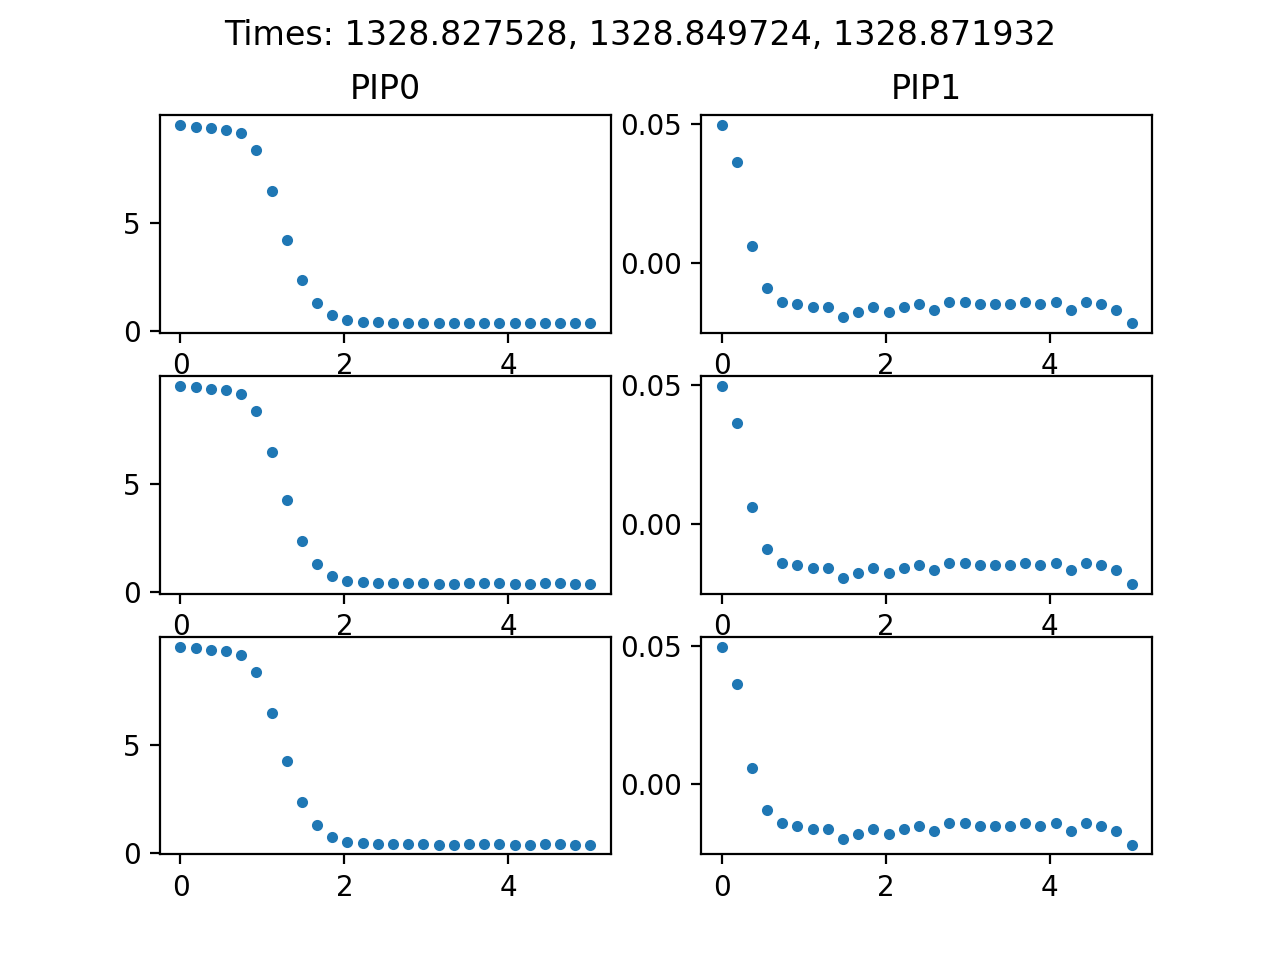

Text(0.5, 0.98, 'Times: 1328.827528, 1328.849724, 1328.871932')

In [106]:
inx = 26000
fig2 = plt.figure(2) 
pip0Current = pip0RptnA[locsrpt].copy()
pip1Current = pip1RptnA[locsrpt].copy()
for idx, plt_inx in zip([[1,2], [3,4], [5, 6]], np.arange(inx-1, inx+2, 1)): 
    ax0 = fig2.add_subplot(3,2, idx[0])
    ax1 = fig2.add_subplot(3,2, idx[1])
    if idx[0]==1: ax0.set_title('PIP0'); ax1.set_title('PIP1')
    ax0.plot(sweep_voltage, np.flip(pip0Current[inx]), '.')
    ax1.plot(sweep_voltage, np.flip(pip1Current[inx]), '.')
fig2.suptitle('Times: %s' % (', '.join([str(val) for val in sweepTimeRpt_trim[inx-1:inx+2]])))